In [4]:
from decoder import *
from encoder import *
from textEncoder import *
from genZero import *
from other_data_loader import *
import pickle
import random
import torch.optim as optim
from torch.autograd import Variable
import csv
import time
from tqdm import tqdm
import gc
import os
import torchvision.transforms as tf
import json
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from matplotlib import pyplot as plt


In [5]:


def validate(val_loader, encoder, decoder, embed, stack, maxSeqLen,
             vocab, lam, batch_size, use_gpu = True):

    
    #Evaluation Mode
    decoder.eval()
    encoder.eval()
    embed.eval()
    stack.eval()
    #lam = 20
    # critereon
    discCrit = nn.BCEWithLogitsLoss()
    textCrit = nn.CrossEntropyLoss()
    distCrit = nn.SmoothL1Loss()
    if use_gpu:
        device = torch.device("cuda:0")
        
    total = 0
    correct = 0
    tp = 0
    tn = 0
    with torch.no_grad():
        
        count    = 0
        loss_avg = 0
        disc_loss_avg = 0
                
        for i, (inputs, labels, lengths) in enumerate(val_loader):
            
            
            
            # Move to device, if available
            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
                        

            #STEM
            embed.resetHidden(labels.shape[0])
            pred_out, w, s = embed(labels, lengths)
            
            #GLAM
            generated_imgs, h0s, discr_gen, discr_real = stackZero(s, inputs)
            
            
            # STREAM
            enc_out = encoder(generated_imgs)

            decoder.resetHidden(inputs.shape[0])
            outputs = decoder(labels, enc_out, lengths) #calls forward
            
            
            loss = (
                    #distCrit(generated_imgs, inputs)
                    lam*textCrit(outputs, labels.cuda())
                    #discCrit(discr_real, torch.ones(discr_real.shape).cuda())
            )
            discloss = (
                    discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda())
                    + discCrit(discr_real, torch.ones(discr_real.shape).cuda())
                )
            loss_avg += loss.item()
            disc_loss_avg += discloss.item()
            count+=1
            
            
            total += inputs.shape[0]*2
            
            bound = torch.ones(inputs.shape[0]).cuda()*0.5
            realOut = torch.where(discr_real.squeeze() > bound,
                                  torch.tensor([1]).cuda(), torch.tensor([0]).cuda())
            fakeOut = torch.where(discr_gen.squeeze() > bound,
                                  torch.tensor([0]).cuda(), torch.tensor([1]).cuda())
#             realOut = torch.where(nn.Sigmoid()(discr_real.squeeze()) > bound,
#                                   torch.tensor([1]).cuda(), torch.tensor([0]).cuda())
#             fakeOut = torch.where(nn.Sigmoid()(discr_gen.squeeze()) > bound,
#                                   torch.tensor([0]).cuda(), torch.tensor([1]).cuda())
            
            tp += torch.sum(realOut).item()
            tn += torch.sum(fakeOut).item()
            correct += (torch.sum(realOut) + torch.sum(fakeOut)).item()
            
            
            del labels
            del inputs
            del outputs            
            
            

                
        loss_avg  = loss_avg/count
        
        disc_loss_avg = disc_loss_avg / count
        print("Discriminator loss: {}".format(disc_loss_avg))
        print("Discriminator Accuracy: {}".format(correct/total))
        print("\nTrue Positive: {}".format(tp))
        print("False Positive (Deceived!): {}".format((total/2) - tn))
        print("True Negative: {}".format(tn))
        print("False Negative: {}".format((total/2) - tp))


        
        
            
    return loss_avg

In [6]:
def trainStack(encoder, decoder, embed, stackZero, epochs, train_loader,val_loader, test_loader,
                        name, batch_size, maxSeqLen, vocab, lam, disc_gen_split, save_generated_imgs= False):
    
    #Create non-existing logfiles
    logname = './logs/' + name + '.log'
    i = 0
    if os.path.exists(logname) == True:
        
        logname = './logs/' + name + str(i) + '.log'
        while os.path.exists(logname):
            i+=1
            logname = './logs/' + name + str(i) + '.log'

    print('Loading results to logfile: ' + logname)
    with open(logname, "w") as file:
        file.write("Log file DATA: Validation Loss and Accuracy\n") 
    
    logname_summary = './logs/' + name + '_summary' + str(i) + '.log'    
    print('Loading Summary to : ' + logname_summary) 
    
    
    try:
        os.mkdir('./generated_imgs')
    except:
        pass
    
    generated_imgs_filename = './generated_imgs/generated_imgs' + name + '_summary' + str(i) + '.log'
    
    parameters = list(stackZero.parameters())
    optimizer = optim.Adam(parameters, lr=2e-4)
    
    lamBuf = lam
    #discCrit = nn.BCEWithLogitsLoss()
    discCrit = nn.BCELoss()
    textCrit = nn.CrossEntropyLoss()
    distCrit = nn.SmoothL1Loss()
    
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        device = torch.device("cuda:0")

        encoder.to(device)
        decoder.to(device)
        embed.to(device)
        stackZero.to(device)
    temperature=1
    
    val_loss_set = []

    training_loss = []
    
    # Early Stop criteria
    minLoss = 1e6
    minLossIdx = 0
    earliestStopEpoch = 7
    earlyStopDelta = 3
    
    val_loss = validate(val_loader, encoder, decoder, embed, stackZero, maxSeqLen,
                             vocab, batch_size, use_gpu)
    for epoch in range(0, epochs):
        ts = time.time()
        
        if epoch % 5 == 0:
            lam = 0
        else:
            lam = lamBuf

        for iter, (inputs, labels, lengths) in tqdm(enumerate(train_loader)):

            optimizer.zero_grad()
            
            stackZero.train()
            encoder.train()
            decoder.train()
            embed.train()
            
            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
            
            
            #For first epoch will train the discriminator/generator everyother iteration
            if epoch ==0:
                #print("0")
                if iter % (10*disc_gen_split) == 0:
                    # Train discriminator
                    for param in stackZero.parameters():
                        param.requires_grad = False
                        
                    stackZero.setDiscriminatorGrad(True)
                    
                else:
                    # Train generator
                    for param in stackZero.parameters():
                        param.requires_grad = True
                    stackZero.setDiscriminatorGrad(False)
#                     discParameters = list(stackZero.D0_down.parameters())
#                     discParameters.extend(stackZero.D0_join.parameters())
#                     discParameters.extend(stackZero.D0_judge.parameters())
#                     for param in discParameters:
#                         param.requires_grad = False
                    
                    
            # After first epoch will train discriminator every 5 epochs
            elif epoch % disc_gen_split == 0:
                
                # Train discriminator
                for param in stackZero.parameters():
                    param.requires_grad = False
                        
                stackZero.setDiscriminatorGrad(True)
                
            else:
                
                # Train generator
                for param in stackZero.parameters():
                    param.requires_grad = True
                        
                stackZero.setDiscriminatorGrad(False)
                
            
            
            
            #STEM
            embed.resetHidden(labels.shape[0])
            pred_out, w, s = embed(labels, lengths)
            
            #GLAM
            generated_imgs, h0s, discr_gen, discr_real = stackZero(s, inputs)
            
            
            # STREAM
            enc_out = encoder(generated_imgs)

            decoder.resetHidden(inputs.shape[0])
            outputs = decoder(labels, enc_out, lengths) #calls forward
            
            #For first epoch will train the discriminator/generator everyother iteration
            if epoch ==0:
                #print("0")
                if iter % (10*disc_gen_split) == 0:
                    # Train discriminator
                    loss = (
                        discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda()) 
                        + discCrit(discr_real, torch.ones(discr_real.shape).cuda())
                    )
                else:
                    # Train generator
                    loss = (
                        #distCrit(generated_imgs, inputs)
                        lam*textCrit(outputs, labels.cuda())
                        + discCrit(discr_gen, torch.ones(discr_real.shape).cuda())
                        #- discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda())
                    )
                    
                    
            # After first epoch will train discriminator every 5 epochs
            elif epoch % disc_gen_split == 0:
                
                # Train discriminator
                loss = (
                        discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda()) 
                        + discCrit(discr_real, torch.ones(discr_real.shape).cuda())
                )
            else:
                
                # Train generator
                loss = (
                    #distCrit(generated_imgs, inputs)
                    lam*textCrit(outputs, labels)
                    + discCrit(discr_gen, torch.ones(discr_real.shape).cuda())
                    #- discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda())
                )
            
#             del labels
#             del outputs

            loss.backward()
#             loss = loss#.item()
            optimizer.step()

            if iter % 200 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))

                
        print("epoch{}, iter{}, loss: {}, epoch duration: {}".format(epoch, iter, loss, time.time() - ts))
        test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()
        
        k = 0
        for b in range(inputs.shape[0]):
            gen_caption = (" ").join(
                [vocab.idx2word[x.item()] for x in test_pred[b] if vocab.idx2word[x.item()] is not '<pad>'])
            raw_caption = (" ").join(
                [vocab.idx2word[x.item()] for x in labels[b] if vocab.idx2word[x.item()] is not '<pad>'])
            gen_img = tf.ToPILImage()(generated_imgs[b,:,:,:].cpu())
            raw_img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
                    
            plt.figure(figsize=(14,8))
            plt.subplot(1,2,1)
            plt.imshow(raw_img)
            plt.subplot(1,2,2)
            plt.imshow(gen_img)      
            plt.show()
            print("Base Caption: " + raw_caption)
            print("Generated Caption: " + gen_caption)
            
            if save_generated_imgs:
                file = "./generated_imgs/" + "train_epoch" + str(epoch) + "im_"+ str(k) 
                img.save(file + ".png", "PNG")
                k+=1
                with open(generated_imgs_filename, "a") as file:
                    file.write("writing! " + "train_epoch" + str(epoch) + "im_"+ str(k) + "\n")            
                    file.write("Caption: " + caption +"\n \n")
        del labels
        del outputs
        # calculate val loss each epoch
        val_loss = validate(val_loader, encoder, decoder, embed, stackZero, maxSeqLen,
                             vocab, batch_size, use_gpu)
        val_loss_set.append(val_loss)

        print("epoch{}, iter{}, val loss: {}, epoch duration: {}".format(epoch, iter, val_loss, time.time() - ts))
        
        training_loss.append(loss)
        
        torch.save(stackZero, 'weights/stack0_{}_epoch{}'.format(name, epoch))

        
        with open(logname, "a") as file:
            file.write("writing!\n")
            file.write("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
            file.write("\n training Loss:   " + str(loss.item()))
            file.write("\n Validation Loss: " + str(val_loss_set[-1]))
                                          
                                                                                                
                                                                                                
        
        # Early stopping
#         if val_loss < minLoss:
#             # Store new best
#             torch.save(stackZero, 'weights/stack0_{}_best'.format(name))
#             minLoss = val_loss#.item()
#             minLossIdx = epoch
            
#         #If passed min threshold, and no new min has been reached for delta epochs
#         elif epoch > earliestStopEpoch and (epoch - minLossIdx) > earlyStopDelta:
#             print("Stopping early at {}".format(minLossIdx))
#             break
        

        
        
        with open(logname_summary, "w") as file:
            file.write("Summary!\n")
            #file.write("Stopped early at {}".format(minLossIdx))
            file.write("\n training Loss:   " + str(training_loss))        
            file.write("\n Validation Loss : " + str(val_loss_set))



found 7323 train ids
found 866 test ids
# ids: 58590
# ids: 14640
# ids: 8660
Loading results to logfile: ./logs/genOnly7.log
Loading Summary to : ./logs/genOnly_summary7.log
Discriminator loss: 1.4492793035963194
Discriminator Accuracy: 0.49760928961748635

True Positive: 14503
False Positive (Deceived!): 14573.0
True Negative: 67
False Negative: 137.0


2it [00:00,  2.60it/s]

epoch0, iter0, loss: 1.5015218257904053


203it [00:19, 10.47it/s]

epoch0, iter200, loss: 0.08417126536369324


402it [00:38, 11.21it/s]

epoch0, iter400, loss: 0.9022138118743896


603it [00:58, 10.48it/s]

epoch0, iter600, loss: 0.6874507665634155


803it [01:17, 10.66it/s]

epoch0, iter800, loss: 0.6836027503013611


1003it [01:36, 10.64it/s]

epoch0, iter1000, loss: 1.2592968940734863


1202it [01:56, 10.35it/s]

epoch0, iter1200, loss: 0.5559743642807007


1402it [02:15, 10.67it/s]

epoch0, iter1400, loss: 1.6098718643188477


1602it [02:34, 10.71it/s]

epoch0, iter1600, loss: 0.2690814137458801


1802it [02:54, 10.61it/s]

epoch0, iter1800, loss: 0.5103181004524231


2003it [03:13, 10.47it/s]

epoch0, iter2000, loss: 1.5842633247375488


2203it [03:32, 10.47it/s]

epoch0, iter2200, loss: 1.8349993228912354


2403it [03:52, 10.56it/s]

epoch0, iter2400, loss: 0.3128482401371002


2601it [04:11, 10.57it/s]

epoch0, iter2600, loss: 0.23891130089759827


2802it [04:30, 10.82it/s]

epoch0, iter2800, loss: 1.1884703636169434


2930it [04:43, 10.35it/s]


epoch0, iter2929, loss: 5.635645389556885, epoch duration: 283.81741404533386


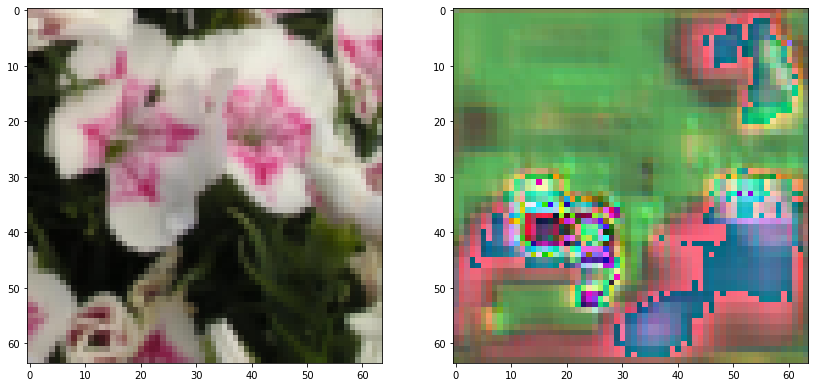

Base Caption: <start> the flowers have small white petals that are also pink in the middle . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a purple center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


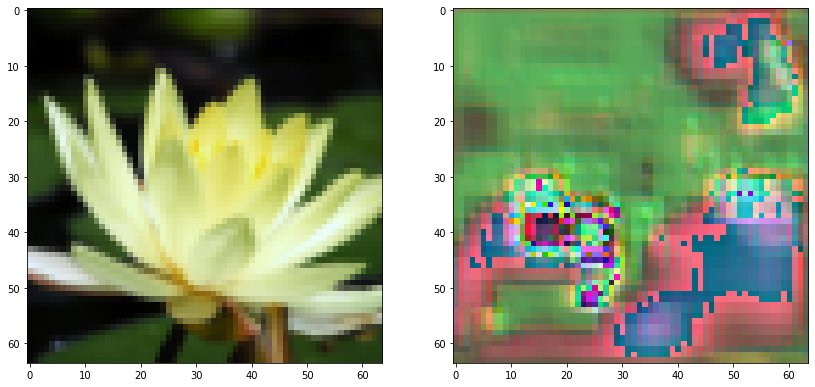

Base Caption: <start> this flower has several upturned layers of white petals with tapered tips . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


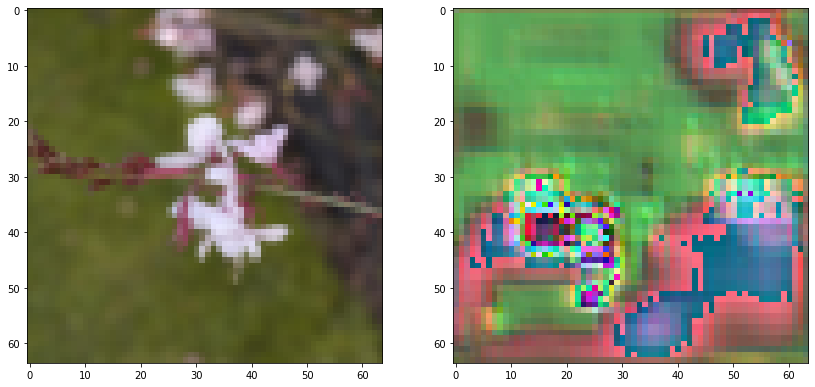

Base Caption: <start> these flowers have white petals with pink receptacles and a green pedicel . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


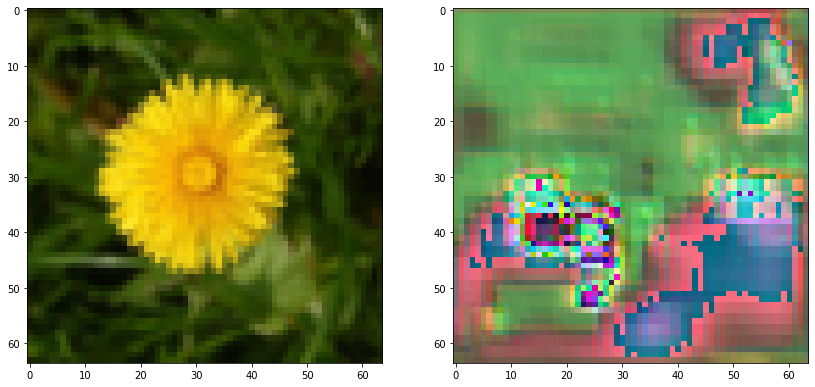

Base Caption: <start> this flower has yellow petals as well as a yellow stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


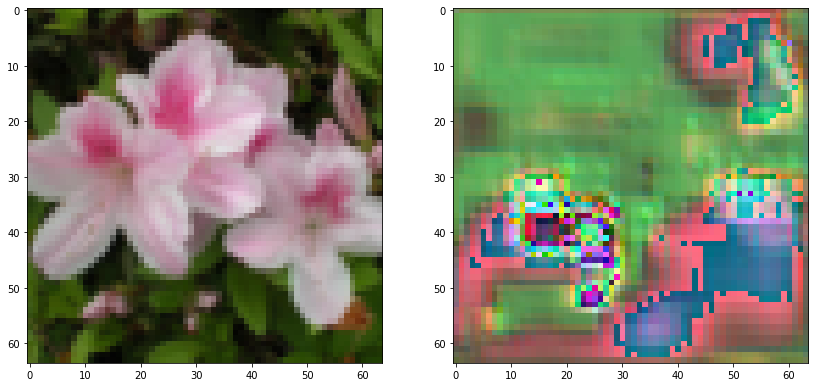

Base Caption: <start> this flower has petals that are white and has purple patches <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


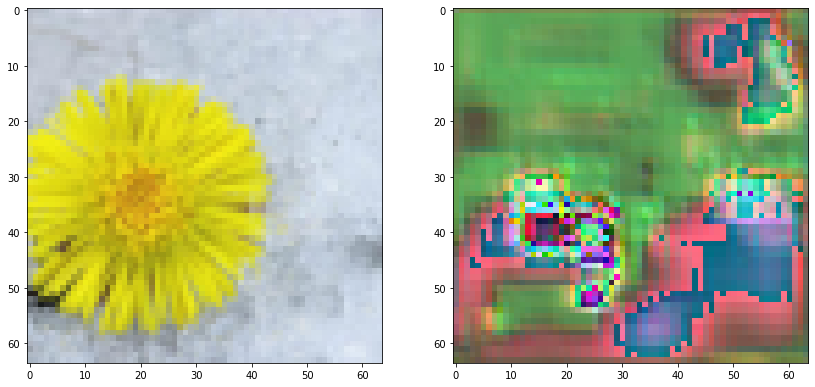

Base Caption: <start> this flower has petals that are yellow and very stringy <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


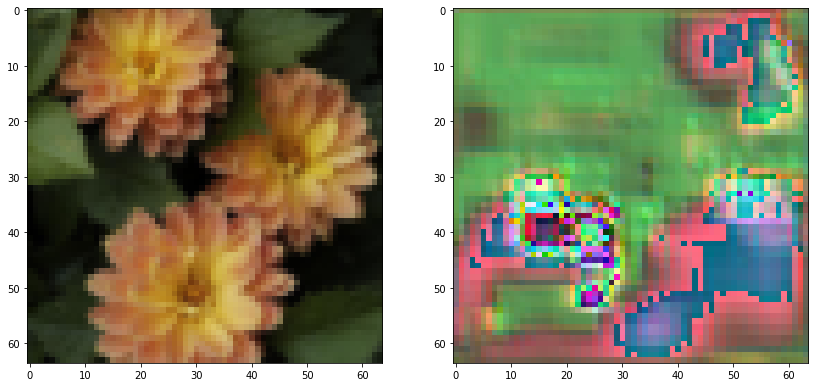

Base Caption: <start> the flower has pink petals that are soft <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are orange and has yellow shading <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


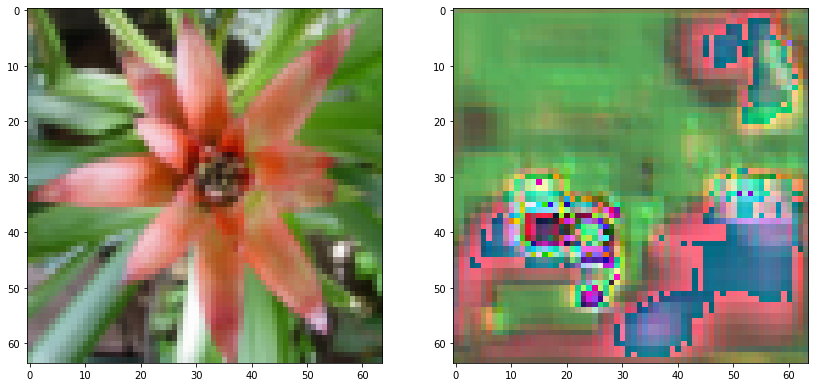

Base Caption: <start> this flower is pink and white in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


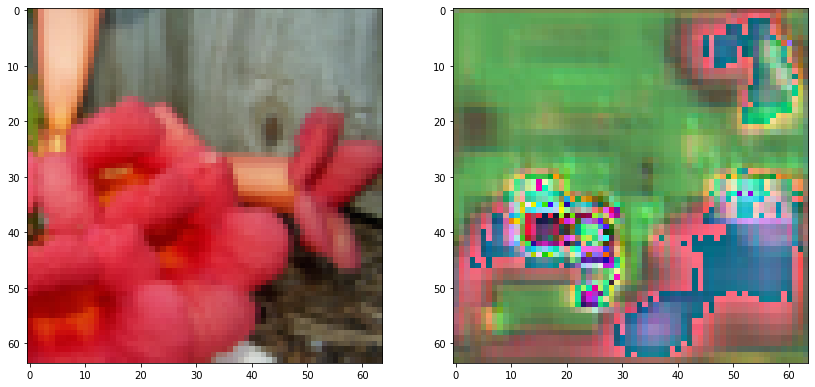

Base Caption: <start> this flower is red in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


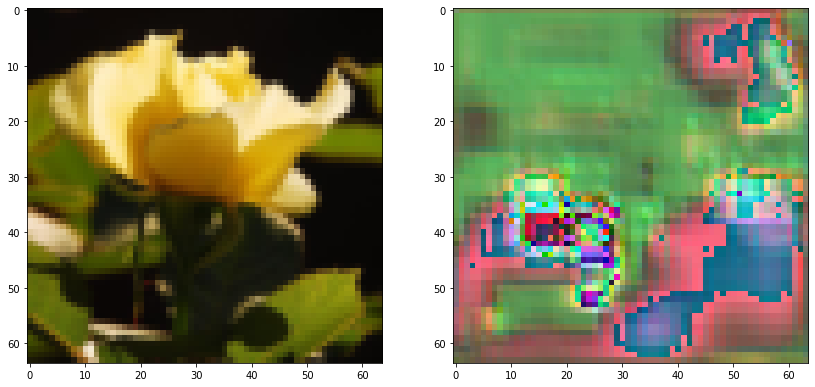

Base Caption: <start> sepals are green <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.120841718273736
Discriminator Accuracy: 0.9099726775956284

True Positive: 12004
False Positive (Deceived!): 0.0
True Negative: 14640
False Negative: 2636.0
epoch0, iter2929, val loss: 9.752748716724374, epoch duration: 328.70144057273865


/home/riley/anaconda3/envs/lowtorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BaseGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/riley/anaconda3/envs/lowtorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/riley/anaconda3/envs/lowtorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/riley/anaconda3/envs/lowtorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Upsample. It won't be checked f

epoch1, iter0, loss: 5.567719459533691


203it [00:20, 10.29it/s]

epoch1, iter200, loss: 0.22999553382396698


403it [00:39, 10.91it/s]

epoch1, iter400, loss: 0.10977234691381454


602it [00:58, 10.20it/s]

epoch1, iter600, loss: 0.077761709690094


802it [01:18, 10.20it/s]

epoch1, iter800, loss: 0.06218058615922928


1002it [01:37,  9.95it/s]

epoch1, iter1000, loss: 0.05202613025903702


1203it [01:57, 10.93it/s]

epoch1, iter1200, loss: 0.04475928097963333


1402it [02:16, 10.12it/s]

epoch1, iter1400, loss: 0.03857393190264702


1602it [02:35, 10.09it/s]

epoch1, iter1600, loss: 0.03349492326378822


1802it [02:55, 10.06it/s]

epoch1, iter1800, loss: 0.029326453804969788


2003it [03:15, 10.26it/s]

epoch1, iter2000, loss: 0.026326123625040054


2201it [03:34, 10.40it/s]

epoch1, iter2200, loss: 0.023629870265722275


2403it [03:54, 10.25it/s]

epoch1, iter2400, loss: 0.021047212183475494


2602it [04:13, 10.02it/s]

epoch1, iter2600, loss: 0.018409932032227516


2802it [04:33, 10.51it/s]

epoch1, iter2800, loss: 0.01588631607592106


2930it [04:45, 10.27it/s]


epoch1, iter2929, loss: 0.014325127005577087, epoch duration: 286.07358956336975


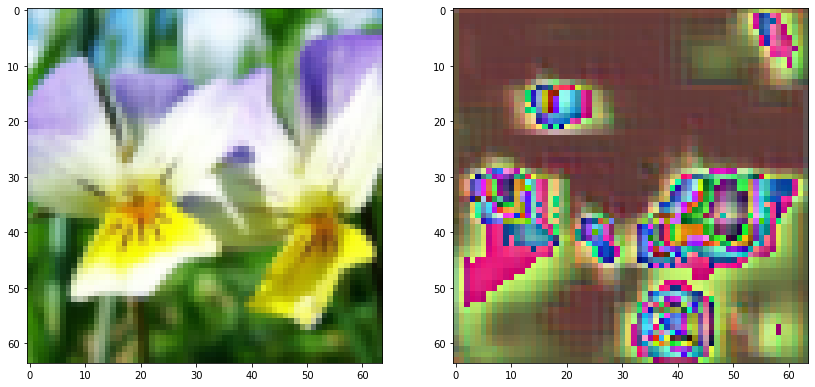

Base Caption: <start> the contrast between the pale violet tips of the upper petals and the yellow and black stripped lower petals are <unk> striking . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


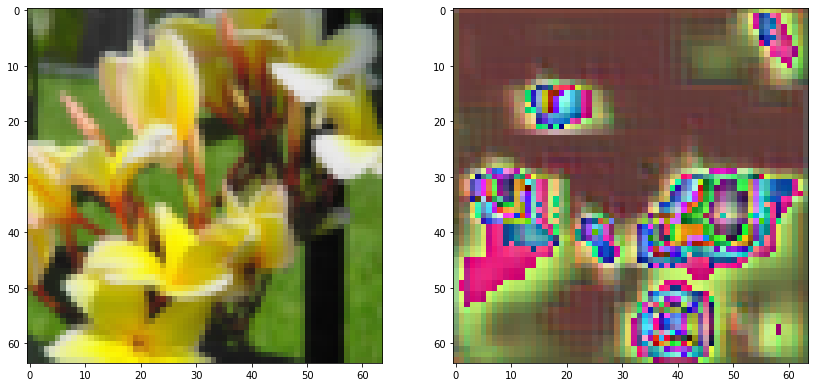

Base Caption: <start> this flower has bright yellow petals with white tips and a red center . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


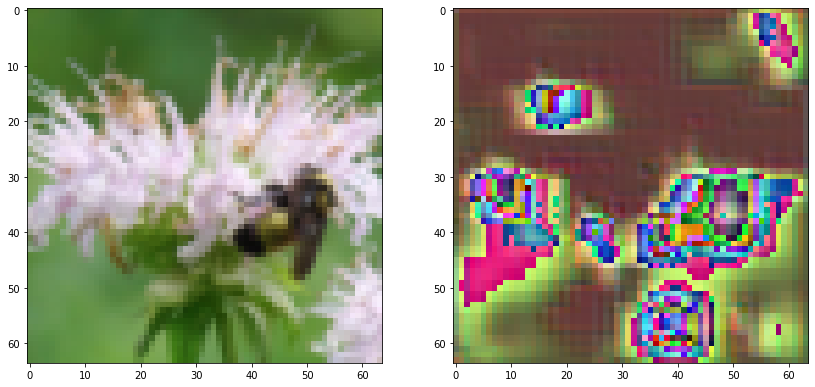

Base Caption: <start> this flower has lots of spiky thin white petals and multiple green sepals . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


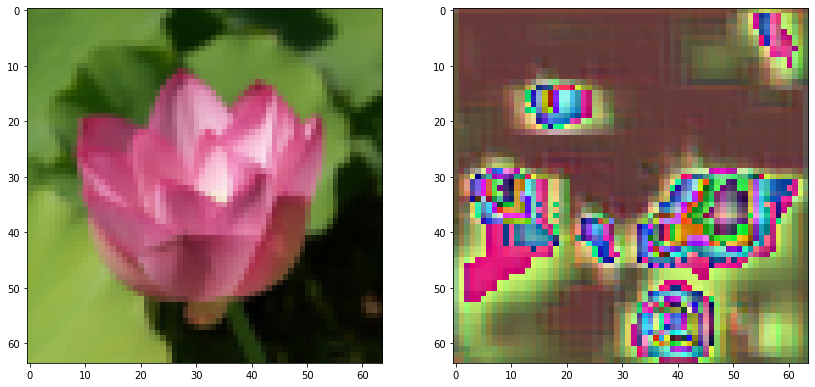

Base Caption: <start> this flower has pointed petals that are pink with lines on them . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


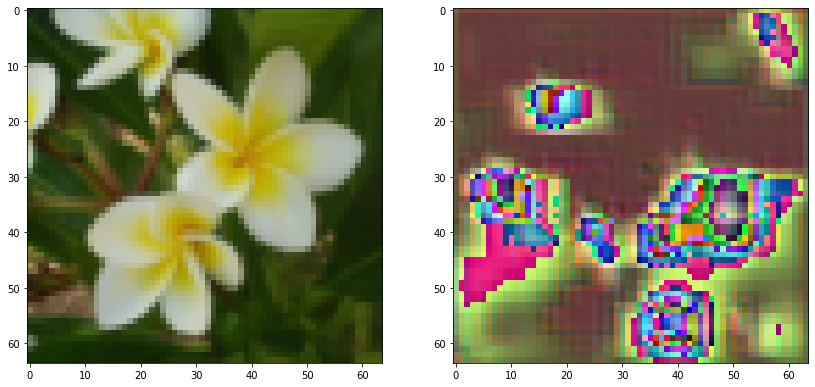

Base Caption: <start> the petals on this flower are white on the fringe with yellow insides <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


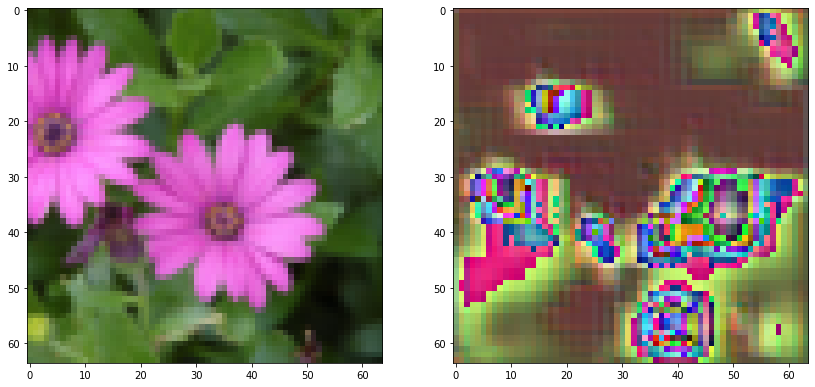

Base Caption: <start> the petals on this flower are purple with yellow stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


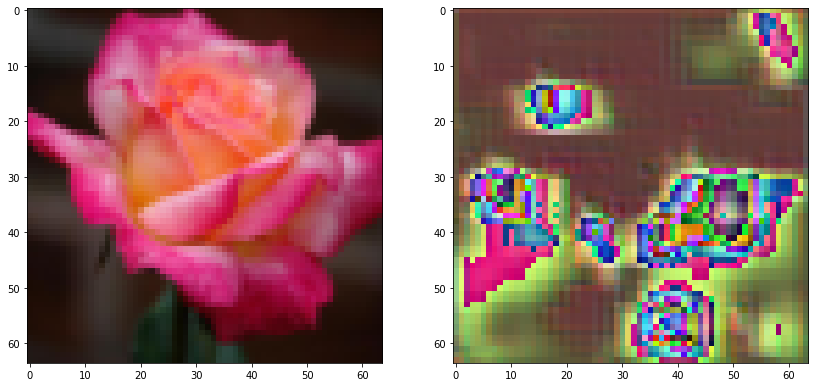

Base Caption: <start> this flower has petals that are pink with shades of yellow <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


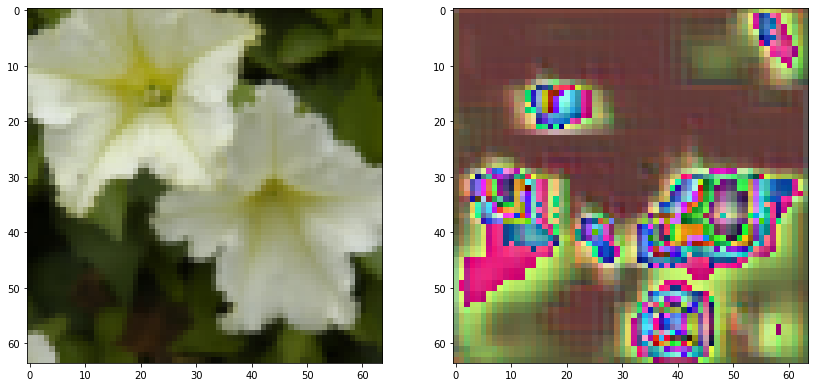

Base Caption: <start> this flower is white and yellow in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


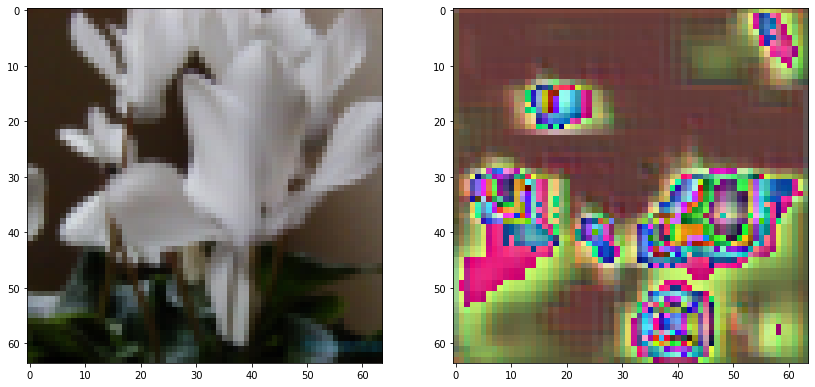

Base Caption: <start> this flower is white in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


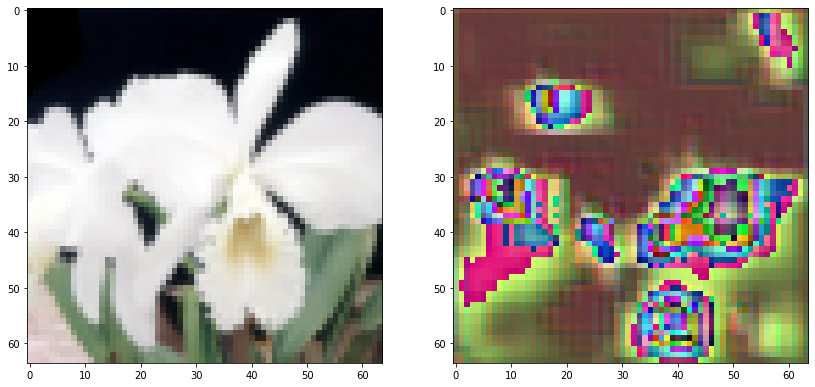

Base Caption: <start> the petals are smooth <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a purple center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.6672582274577656
Discriminator Accuracy: 0.4948770491803279

True Positive: 14490
False Positive (Deceived!): 14640.0
True Negative: 0
False Negative: 150.0
epoch1, iter2929, val loss: 9.48169595426549, epoch duration: 331.478168964386


1it [00:00,  3.17it/s]

epoch2, iter0, loss: 0.0143010588362813


203it [00:20, 10.43it/s]

epoch2, iter200, loss: 0.011797594837844372


403it [00:40, 10.17it/s]

epoch2, iter400, loss: 0.009414587169885635


602it [00:59, 10.30it/s]

epoch2, iter600, loss: 0.00743208359926939


803it [01:19, 10.00it/s]

epoch2, iter800, loss: 0.006082490552216768


1003it [01:39, 10.03it/s]

epoch2, iter1000, loss: 0.005169286392629147


1202it [01:58, 10.70it/s]

epoch2, iter1200, loss: 0.004505313001573086


1402it [02:17, 10.02it/s]

epoch2, iter1400, loss: 0.0039591239765286446


1601it [02:37, 10.23it/s]

epoch2, iter1600, loss: 0.0034803233575075865


1801it [02:56, 10.38it/s]

epoch2, iter1800, loss: 0.0030689830891788006


2003it [03:16, 10.15it/s]

epoch2, iter2000, loss: 0.002715559210628271


2202it [03:36,  9.98it/s]

epoch2, iter2200, loss: 0.0024057929404079914


2402it [03:55, 10.90it/s]

epoch2, iter2400, loss: 0.0021400635596364737


2603it [04:15, 10.07it/s]

epoch2, iter2600, loss: 0.0018922664457932115


2802it [04:34, 10.00it/s]

epoch2, iter2800, loss: 0.0016742178704589605


2930it [04:47, 10.20it/s]


epoch2, iter2929, loss: 0.0015533349942415953, epoch duration: 287.9374563694


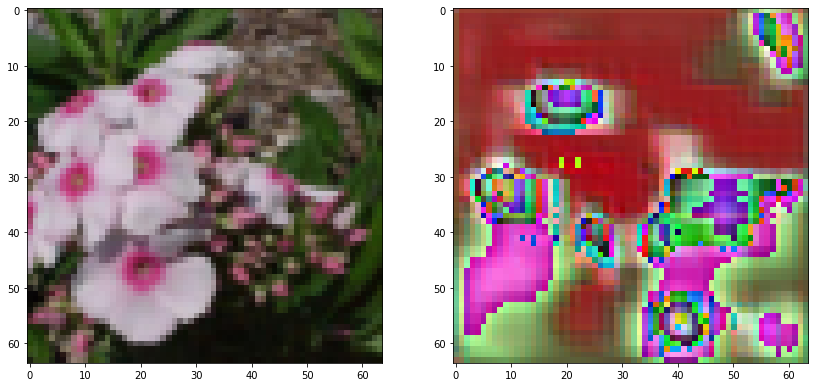

Base Caption: <start> this flower is characterized by its light pink petals <unk> with a dark pink circular band on the inside of each petal . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a white center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


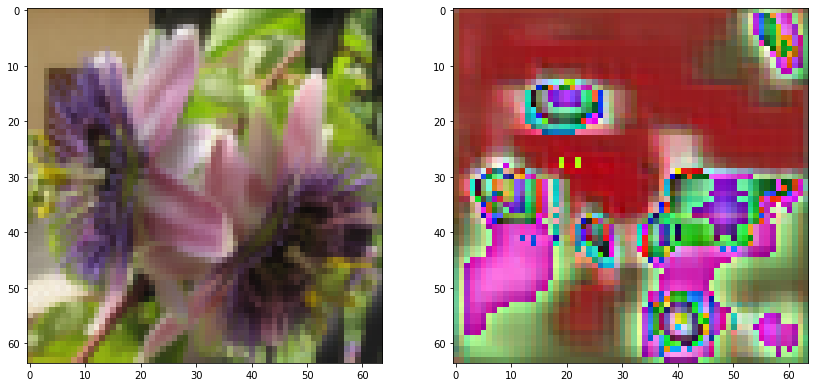

Base Caption: <start> this flower has a green stigma protruding out of the middle of many tiny lavender stamens embedded on pink petals . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


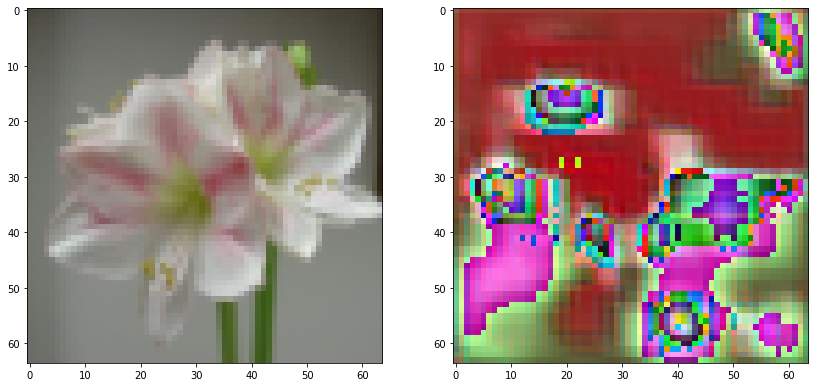

Base Caption: <start> the flowers has a set of white petals with streaks and patches of pink color towards the middle . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


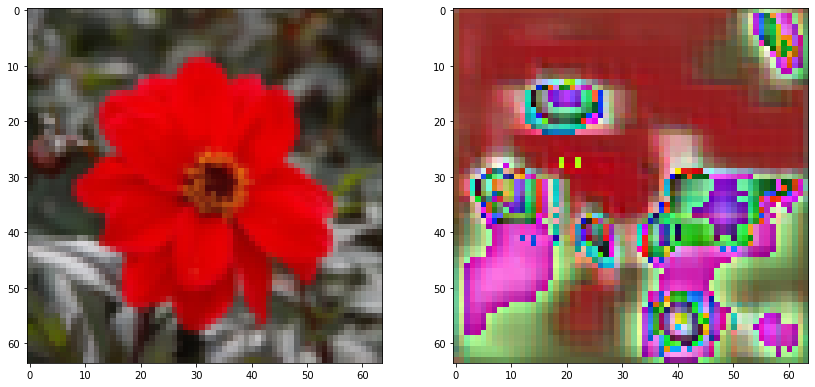

Base Caption: <start> this flower has several overlapping layers of large red petals with rounded tips and a smooth texture . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has red lines <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


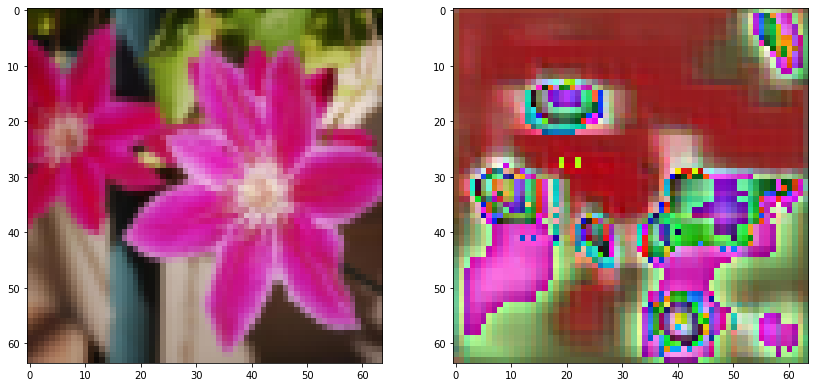

Base Caption: <start> this fuschia with white filament star shaped flower grows on a vine . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


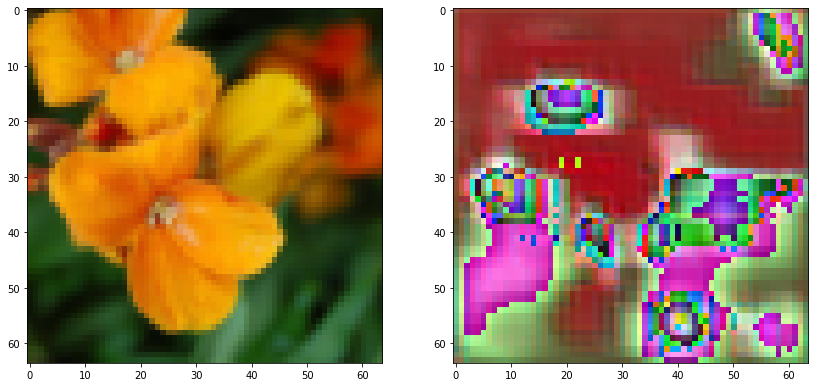

Base Caption: <start> this orange and yellow flower has rounded petals and a white anthers . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


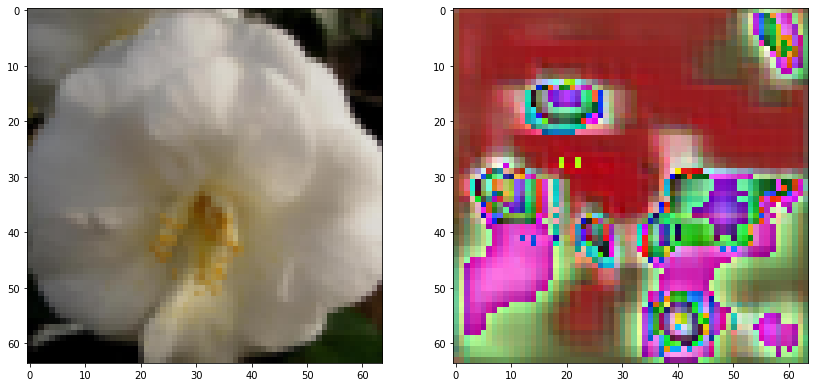

Base Caption: <start> this white flower has multiple petals with white filaments and yellow anthers . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


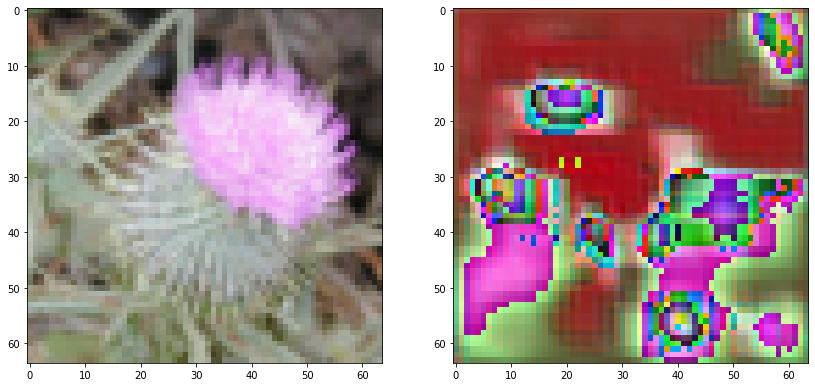

Base Caption: <start> this flower has petals that are green and has purple stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


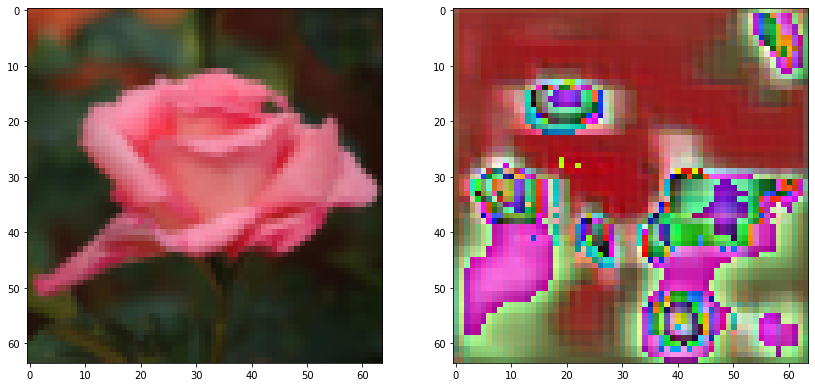

Base Caption: <start> the flower shown has pink petals with a green pedicel <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


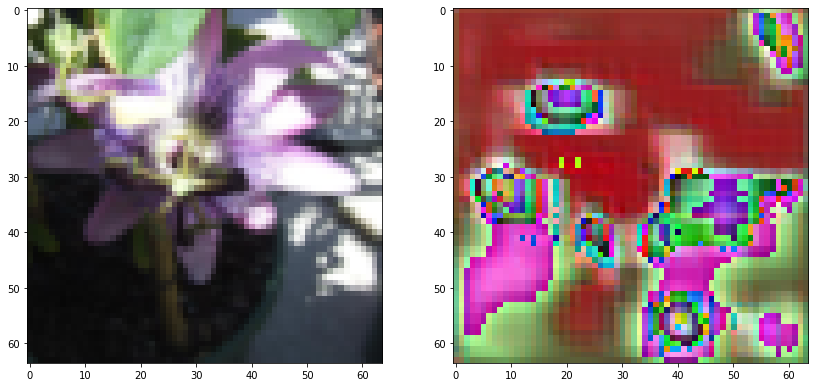

Base Caption: <start> the flower has eight purple petals and five stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.6468029098758281
Discriminator Accuracy: 0.4962431693989071

True Positive: 14530
False Positive (Deceived!): 14640.0
True Negative: 0
False Negative: 110.0
epoch2, iter2929, val loss: 9.742177044759032, epoch duration: 333.12936902046204


3it [00:00,  2.39it/s]

epoch3, iter0, loss: 0.0015530071686953306


202it [00:20,  9.82it/s]

epoch3, iter200, loss: 0.001385912881232798


403it [00:40, 10.22it/s]

epoch3, iter400, loss: 0.001242599100805819


603it [00:59, 10.17it/s]

epoch3, iter600, loss: 0.0011220372980460525


801it [01:19, 10.16it/s]

epoch3, iter800, loss: 0.0010093955788761377


1002it [01:39, 10.44it/s]

epoch3, iter1000, loss: 0.0009086774662137032


1202it [01:58, 10.73it/s]

epoch3, iter1200, loss: 0.0008209770312532783


1401it [02:18, 10.10it/s]

epoch3, iter1400, loss: 0.0007441402412950993


1602it [02:37, 10.16it/s]

epoch3, iter1600, loss: 0.0006738429656252265


1803it [02:57, 10.30it/s]

epoch3, iter1800, loss: 0.0006110926042310894


2003it [03:16, 10.98it/s]

epoch3, iter2000, loss: 0.0005561079597100616


2203it [03:35, 10.49it/s]

epoch3, iter2200, loss: 0.0005104296142235398


2403it [03:55, 10.09it/s]

epoch3, iter2400, loss: 0.0004707908374257386


2603it [04:15, 10.06it/s]

epoch3, iter2600, loss: 0.00043414122774265707


2801it [04:34, 10.75it/s]

epoch3, iter2800, loss: 0.00040195914334617555


2930it [04:47, 10.21it/s]


epoch3, iter2929, loss: 0.0003834506496787071, epoch duration: 287.7450227737427


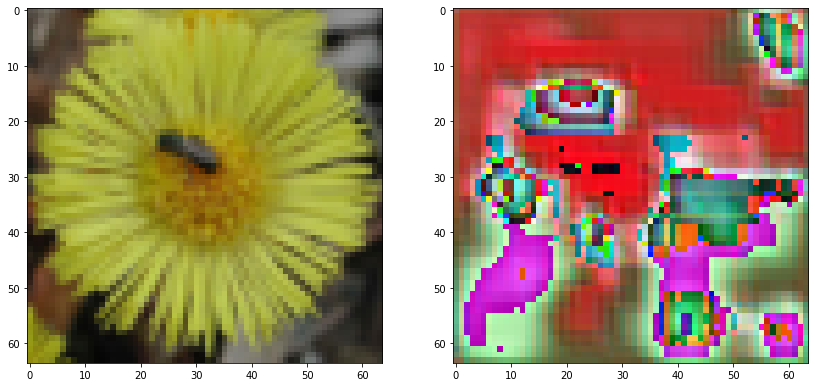

Base Caption: <start> the flower has many small pointy yellow petals with yellow anther in the center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


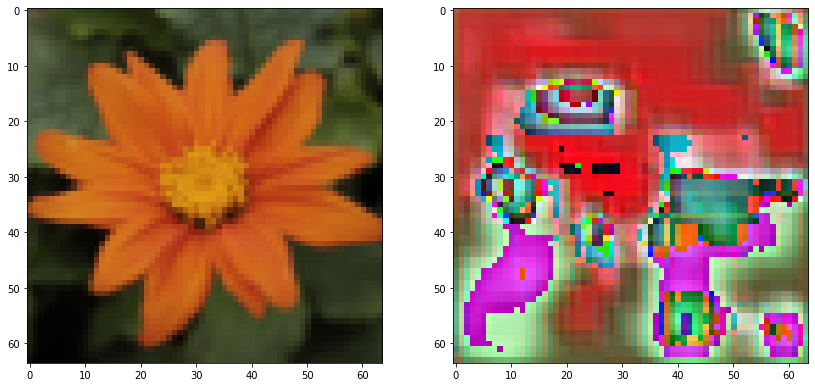

Base Caption: <start> this flower has orange petals as well as a yellow pistil . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


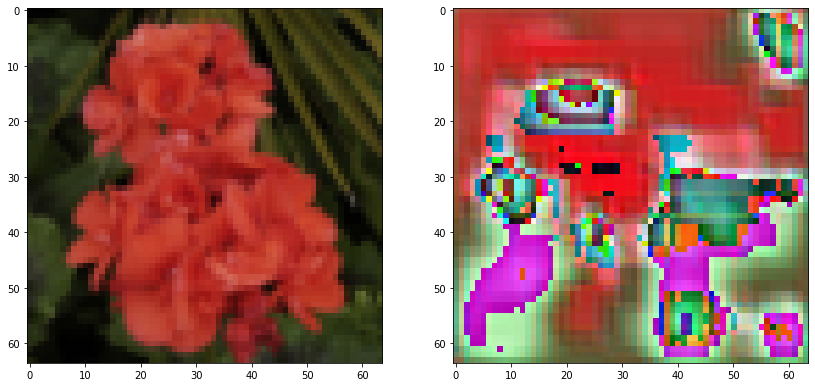

Base Caption: <start> this flower has a dark red petal and a red stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


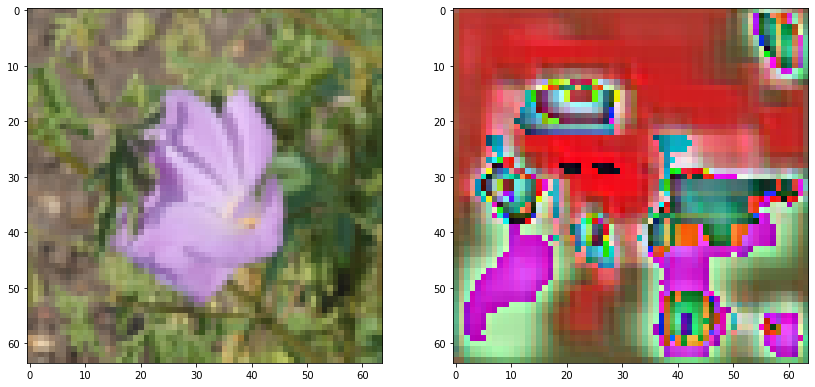

Base Caption: <start> these petals are light purple and overlap like a fan . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a flowery stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


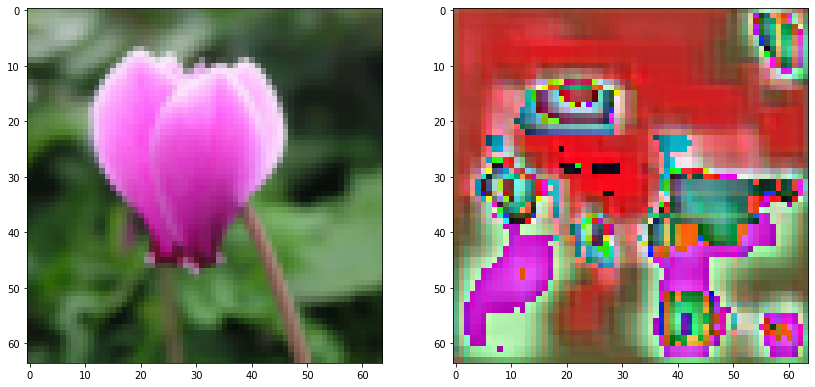

Base Caption: <start> this flower is pink and white in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


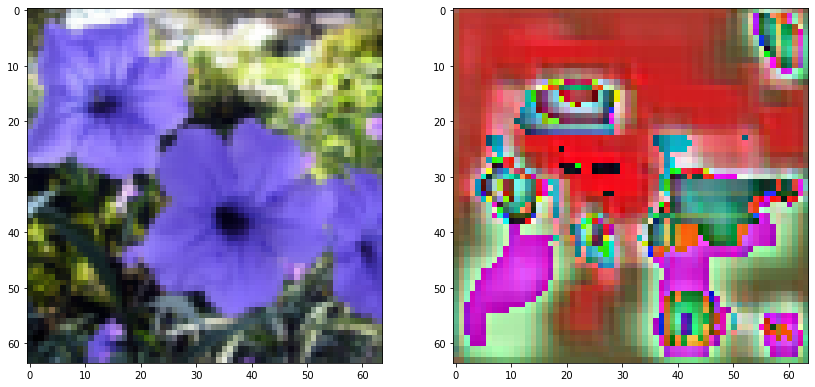

Base Caption: <start> rounded blue petals surround a dark center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are orange and has yellow edges <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


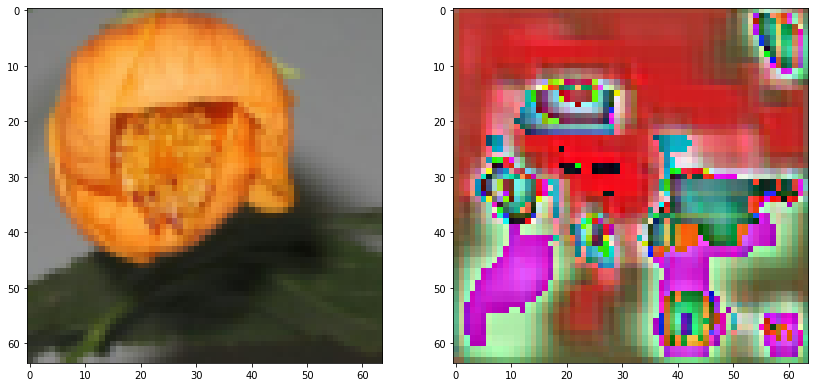

Base Caption: <start> this flower has many bright orange stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


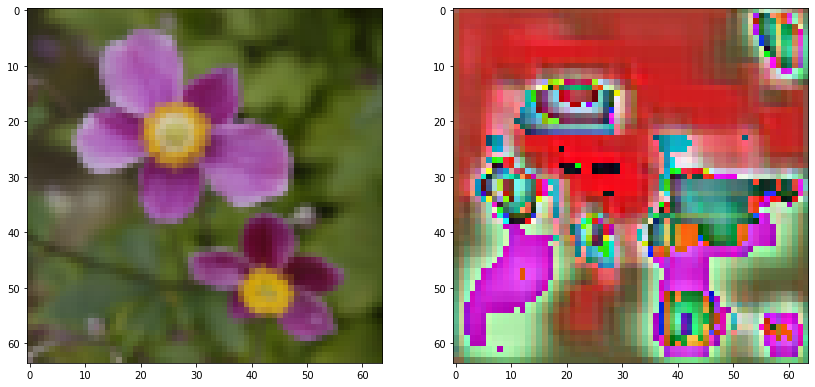

Base Caption: <start> two purple flowers with five petals each <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


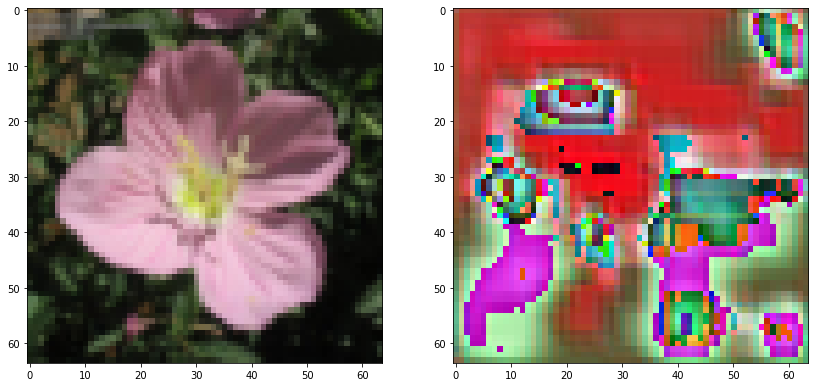

Base Caption: <start> this flower is pink in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has pink edges <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


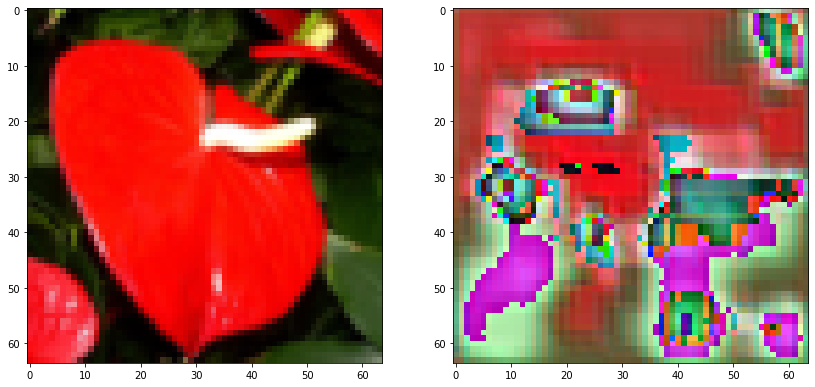

Base Caption: <start> the flower has one large <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.6424418829503606
Discriminator Accuracy: 0.49556010928961747

True Positive: 14510
False Positive (Deceived!): 14640.0
True Negative: 0
False Negative: 130.0
epoch3, iter2929, val loss: 9.554588806433756, epoch duration: 333.0627956390381


3it [00:00,  3.29it/s]

epoch4, iter0, loss: 7.984240531921387


203it [00:15, 13.06it/s]

epoch4, iter200, loss: 0.0004945712280459702


403it [00:31, 12.76it/s]

epoch4, iter400, loss: 0.00021508443751372397


603it [00:47, 12.39it/s]

epoch4, iter600, loss: 0.00012445656466297805


803it [01:03, 12.65it/s]

epoch4, iter800, loss: 0.00018816183728631586


1003it [01:18, 12.68it/s]

epoch4, iter1000, loss: 8.136611722875386e-05


1203it [01:34, 12.89it/s]

epoch4, iter1200, loss: 8.75801415531896e-05


1403it [01:50, 12.02it/s]

epoch4, iter1400, loss: 6.169723928906024e-05


1603it [02:05, 12.46it/s]

epoch4, iter1600, loss: 3.0619234166806564e-05


1803it [02:21, 12.54it/s]

epoch4, iter1800, loss: 2.198832225985825e-05


2003it [02:36, 13.14it/s]

epoch4, iter2000, loss: 1.7786160242394544e-05


2203it [02:52, 13.10it/s]

epoch4, iter2200, loss: 5.546617103391327e-05


2403it [03:08, 12.79it/s]

epoch4, iter2400, loss: 1.8942770111607388e-05


2603it [03:23, 13.30it/s]

epoch4, iter2600, loss: 1.6114263416966423e-05


2803it [03:40, 12.79it/s]

epoch4, iter2800, loss: 1.7533118807477877e-05


2930it [03:50, 12.73it/s]


epoch4, iter2929, loss: 9.673867680248804e-06, epoch duration: 230.89406633377075


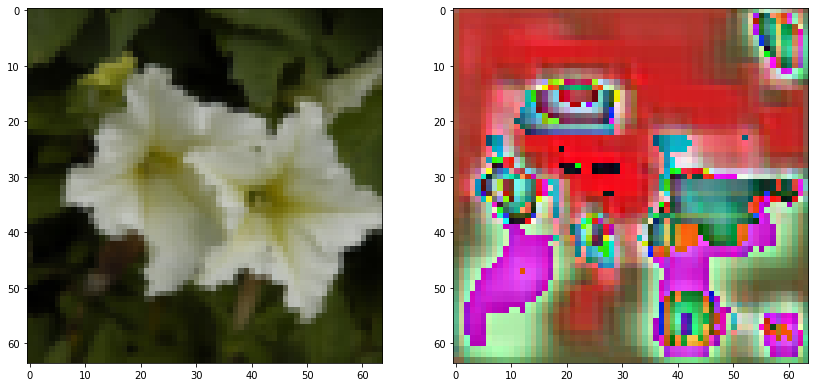

Base Caption: <start> these flowers have white petals with yellow stamen in the center of them . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has purple dots <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


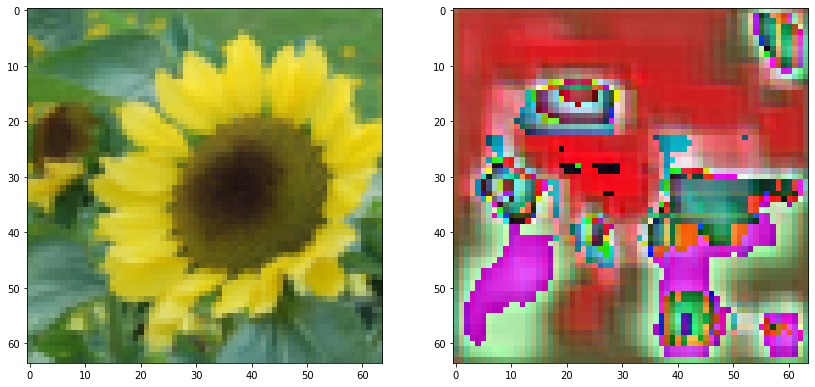

Base Caption: <start> the flower shown has yellow petals to go with darker anther and filament <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has a big style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


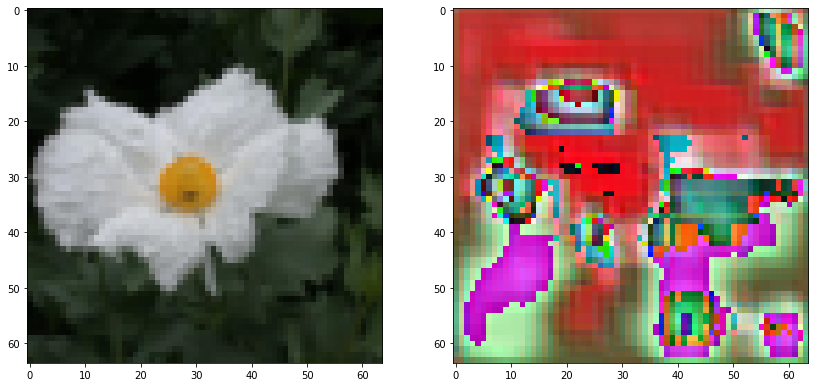

Base Caption: <start> a white flower with ruffled petals and a tiny yellow stigma . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has a big style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


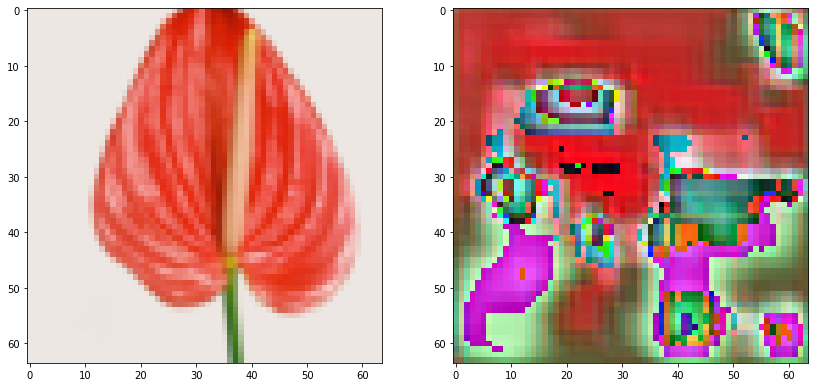

Base Caption: <start> this flower has red petals as well as a green pedicel . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


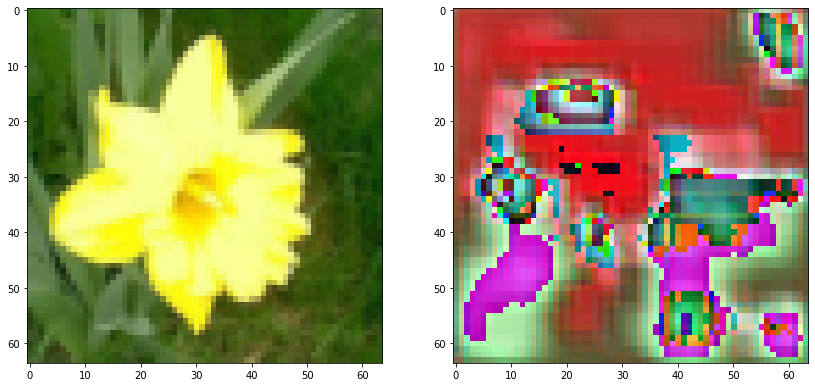

Base Caption: <start> a puffy looking bright yellow flower with a <unk> deep center . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


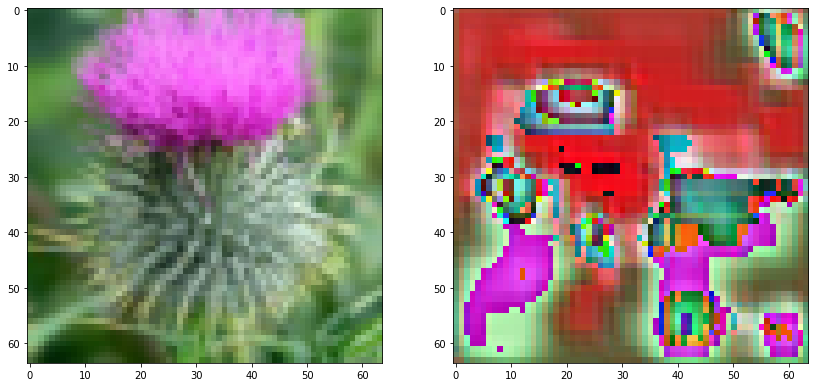

Base Caption: <start> this flower has a dense amount of thin spike-shaped purple petals . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has a big style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


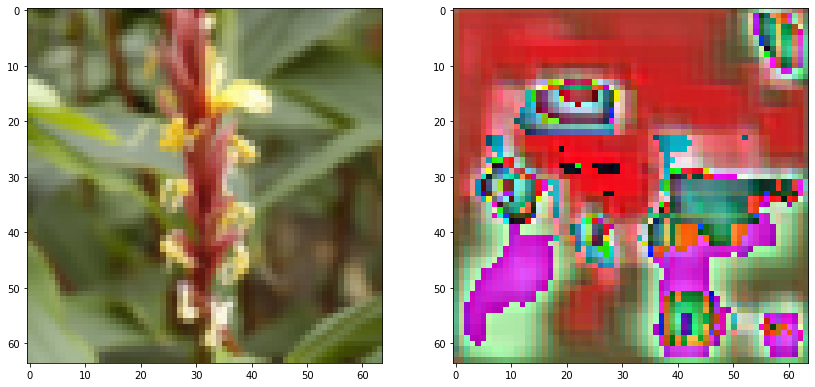

Base Caption: <start> a flower with red and yellow petals and large green leaves . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has a big style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


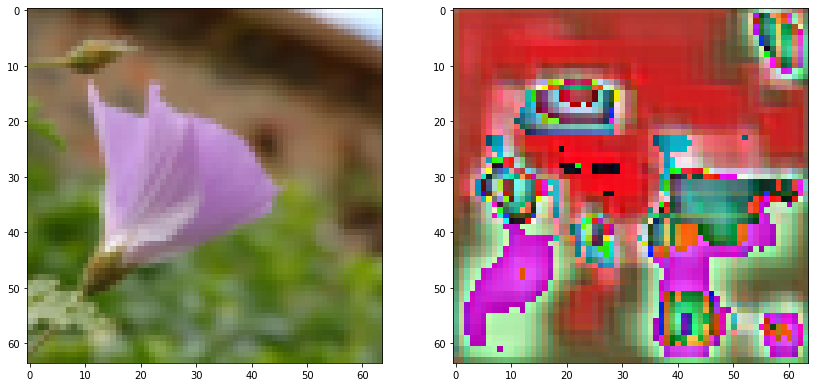

Base Caption: <start> this flower has a purple petal and no visible outer stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


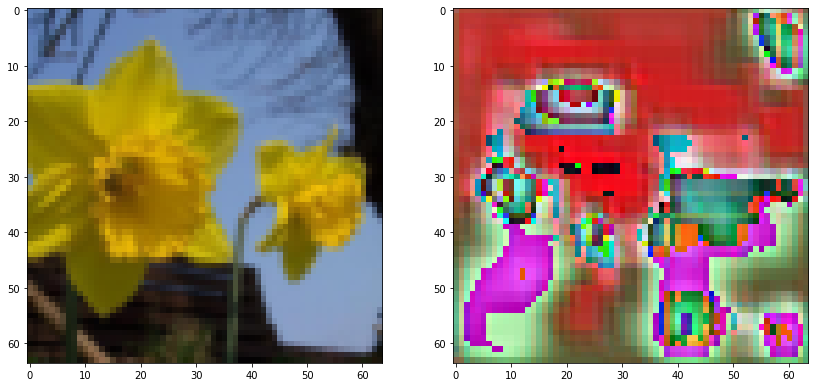

Base Caption: <start> this flower has large yellow petals and long yellow stamens . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


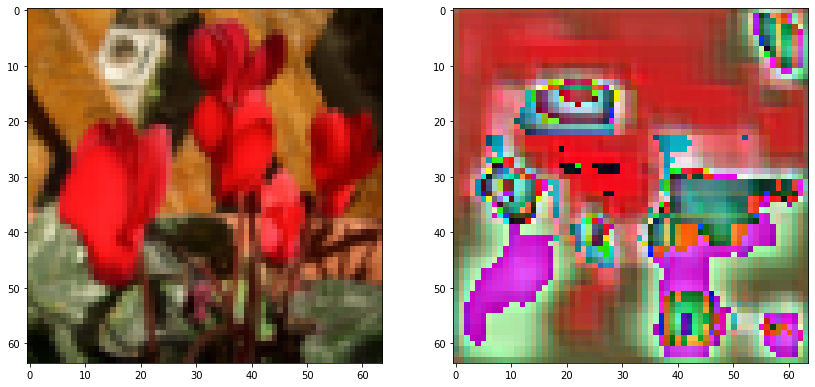

Base Caption: <start> red <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a white center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.0064524162988193
Discriminator Accuracy: 0.9999658469945355

True Positive: 14640
False Positive (Deceived!): 1.0
True Negative: 14639
False Negative: 0.0
epoch4, iter2929, val loss: 9.512702119806425, epoch duration: 275.49009251594543


2it [00:00,  4.50it/s]

epoch5, iter0, loss: 12.093213081359863


202it [00:19, 10.13it/s]

epoch5, iter200, loss: 8.821526535029989e-06


401it [00:39,  9.99it/s]

epoch5, iter400, loss: 8.732118658372201e-06


603it [00:58, 11.12it/s]

epoch5, iter600, loss: 8.66655318532139e-06


802it [01:18, 10.31it/s]

epoch5, iter800, loss: 8.702316335984506e-06


1003it [01:37, 10.15it/s]

epoch5, iter1000, loss: 8.67251401359681e-06


1202it [01:57, 10.03it/s]

epoch5, iter1200, loss: 8.702316335984506e-06


1402it [02:16, 10.20it/s]

epoch5, iter1400, loss: 8.618868378107436e-06


1603it [02:36, 10.11it/s]

epoch5, iter1600, loss: 8.535421329725068e-06


1803it [02:55, 10.69it/s]

epoch5, iter1800, loss: 8.43409179651644e-06


2002it [03:15, 10.52it/s]

epoch5, iter2000, loss: 8.46985676616896e-06


2203it [03:34, 10.33it/s]

epoch5, iter2200, loss: 8.469854947179556e-06


2403it [03:53, 10.45it/s]

epoch5, iter2400, loss: 8.350645657628775e-06


2602it [04:13, 10.27it/s]

epoch5, iter2600, loss: 8.493698260281235e-06


2802it [04:32, 10.35it/s]

epoch5, iter2800, loss: 8.189712389139459e-06


2930it [04:45, 10.26it/s]


epoch5, iter2929, loss: 8.237396286858711e-06, epoch duration: 286.2431366443634


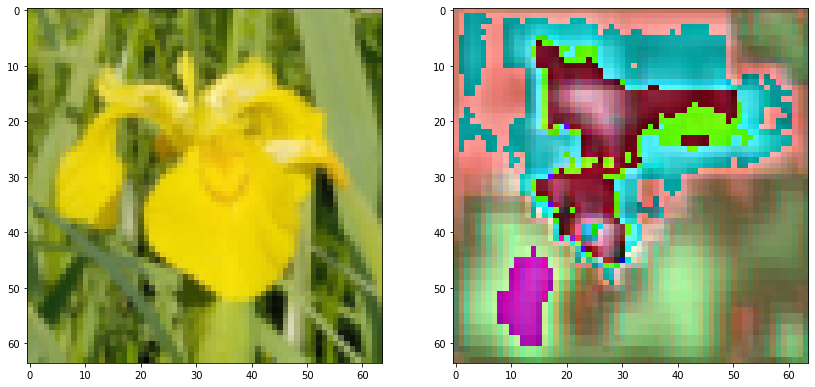

Base Caption: <start> this flower has wide yellow petals which are hanging and drooping from the pollen tube . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


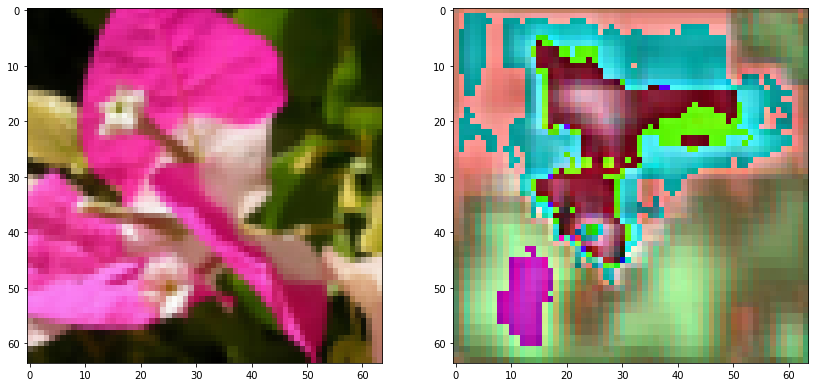

Base Caption: <start> this flower has a tiny white blossom surrounded by pointed pink petals with leaflike veins . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


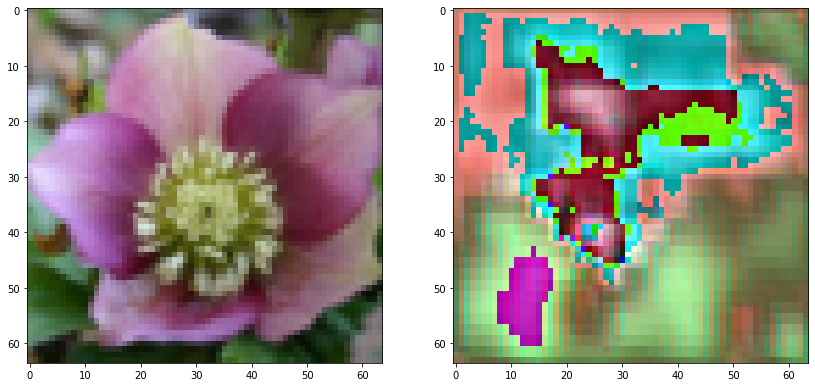

Base Caption: <start> the petals are purple with visible veins and the stamen are green and clustered . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


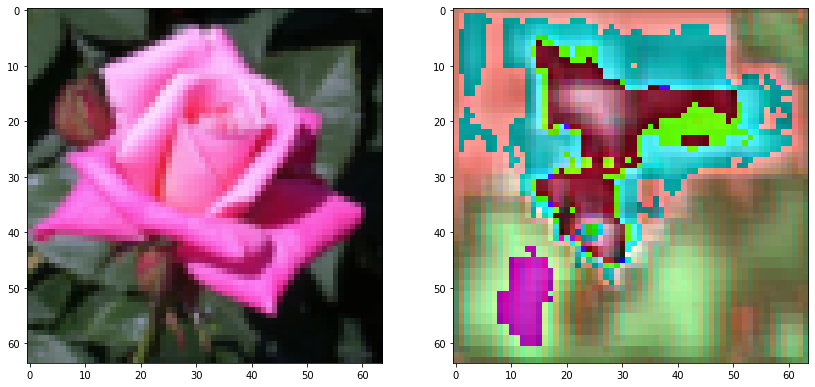

Base Caption: <start> the petals on this flower are pink with no visible stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


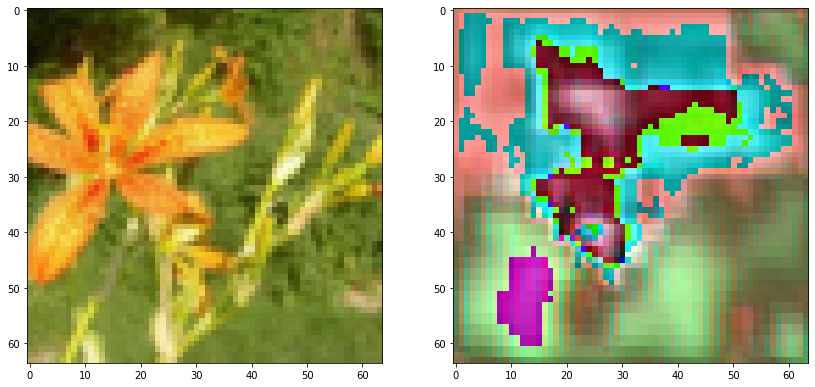

Base Caption: <start> this flower has a long orange petal with yellow dots on it <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


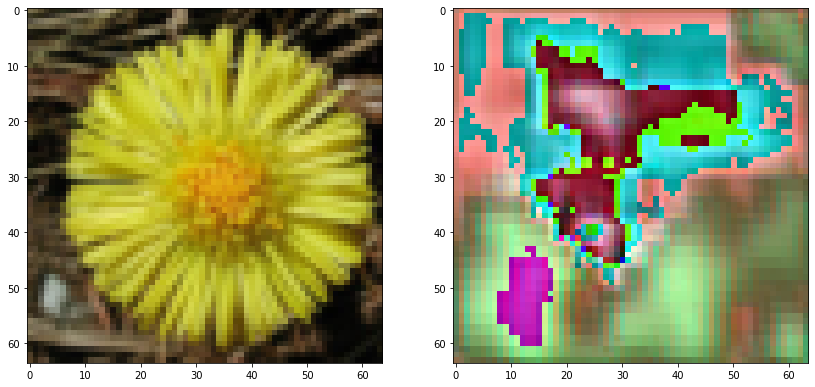

Base Caption: <start> this flower has petals that are yellow and is very stringy <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


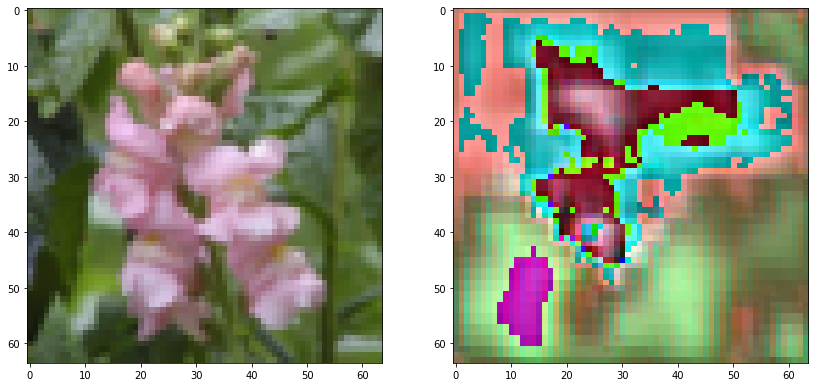

Base Caption: <start> this flower has pink petals that have patches of yellow <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


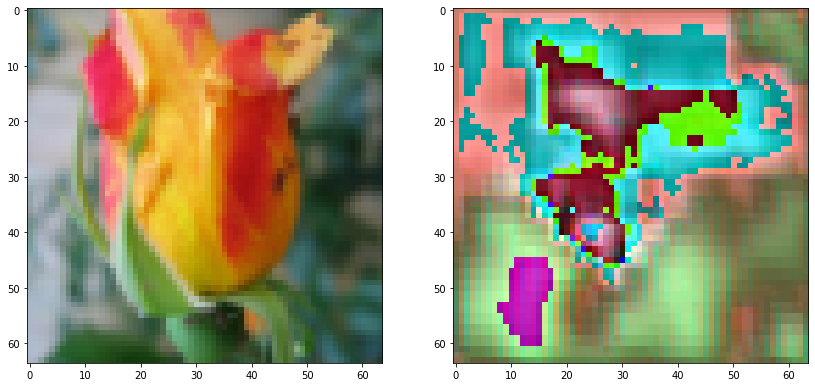

Base Caption: <start> this flower is yellow red and orange in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


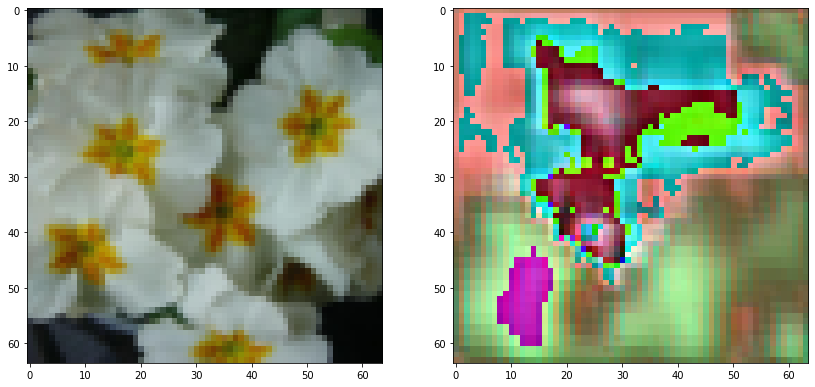

Base Caption: <start> the petals on this flower are mostly white <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a white center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


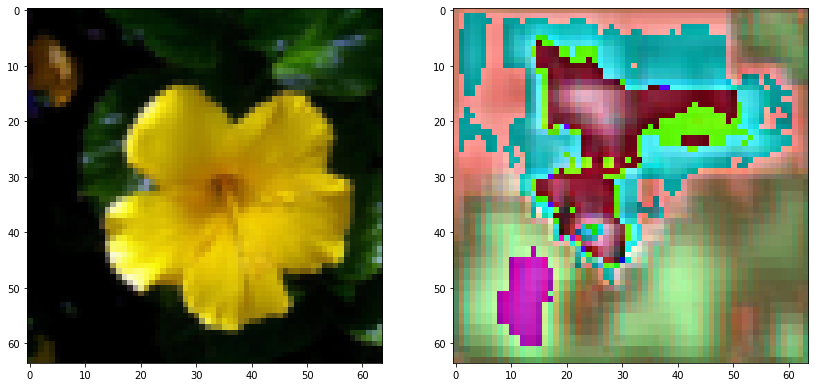

Base Caption: <start> this flower is yellow in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a yellow style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.626524285051992
Discriminator Accuracy: 0.5

True Positive: 14640
False Positive (Deceived!): 14640.0
True Negative: 0
False Negative: 0.0
epoch5, iter2929, val loss: 9.544788251157668, epoch duration: 331.285959482193


2it [00:00,  3.17it/s]

epoch6, iter0, loss: 8.159909157257061e-06


201it [00:19, 10.40it/s]

epoch6, iter200, loss: 8.130106834869366e-06


403it [00:39, 10.37it/s]

epoch6, iter400, loss: 8.034738129936159e-06


602it [00:58,  9.64it/s]

epoch6, iter600, loss: 7.951291991048492e-06


803it [01:18, 10.25it/s]

epoch6, iter800, loss: 7.766515409457497e-06


1002it [01:37,  9.85it/s]

epoch6, iter1000, loss: 7.82016013545217e-06


1203it [01:57, 10.45it/s]

epoch6, iter1200, loss: 7.76055549067678e-06


1403it [02:16, 10.00it/s]

epoch6, iter1400, loss: 7.379082035186002e-06


1602it [02:36, 10.12it/s]

epoch6, iter1600, loss: 7.2837137850001454e-06


1803it [02:55, 10.75it/s]

epoch6, iter1800, loss: 7.2002667366177775e-06


2002it [03:14,  9.31it/s]

epoch6, iter2000, loss: 7.164503585954662e-06


2202it [03:34, 10.95it/s]

epoch6, iter2200, loss: 7.057214588712668e-06


2402it [03:53, 10.57it/s]

epoch6, iter2400, loss: 6.717466021655127e-06


2603it [04:13, 11.05it/s]

epoch6, iter2600, loss: 6.5028884819184896e-06


2801it [04:32, 10.02it/s]

epoch6, iter2800, loss: 6.318112809822196e-06


2930it [04:45, 10.27it/s]


epoch6, iter2929, loss: 6.234665306692477e-06, epoch duration: 285.91189193725586


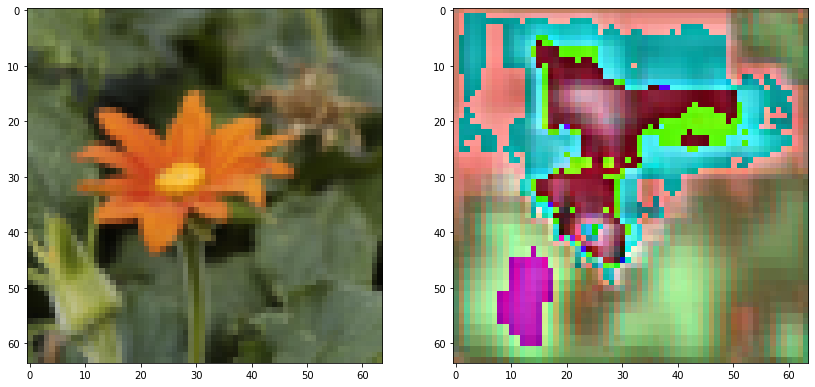

Base Caption: <start> this flower has a green sepal and bright orange petals that form a disk arrangement . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


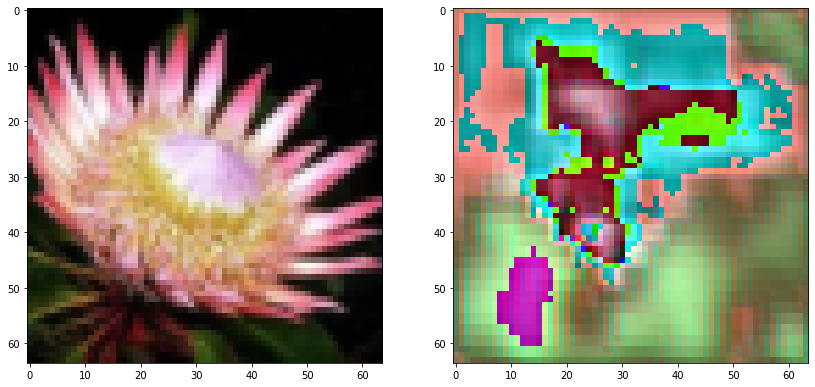

Base Caption: <start> this flower has petals that are pink and very think with green stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a purple center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


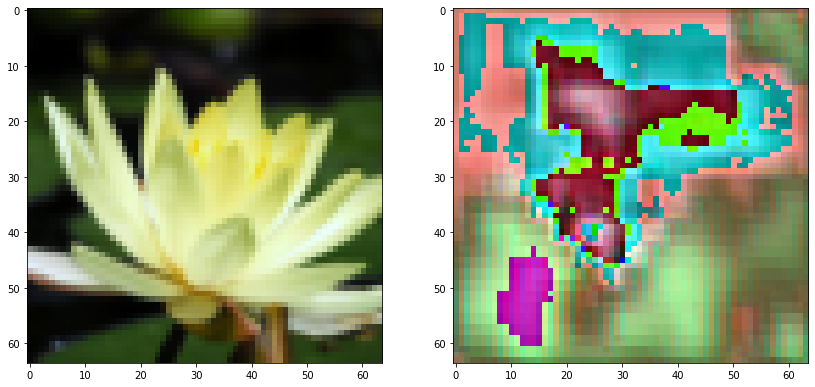

Base Caption: <start> this flower has white pointed petals and no visible stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


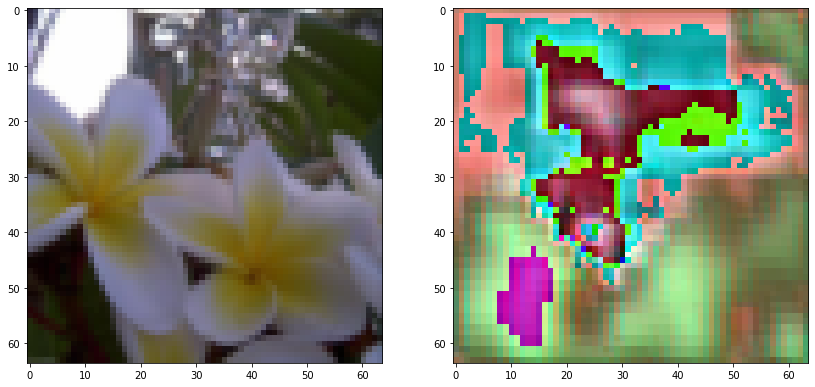

Base Caption: <start> this flower has petals that are yellow with white edges <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


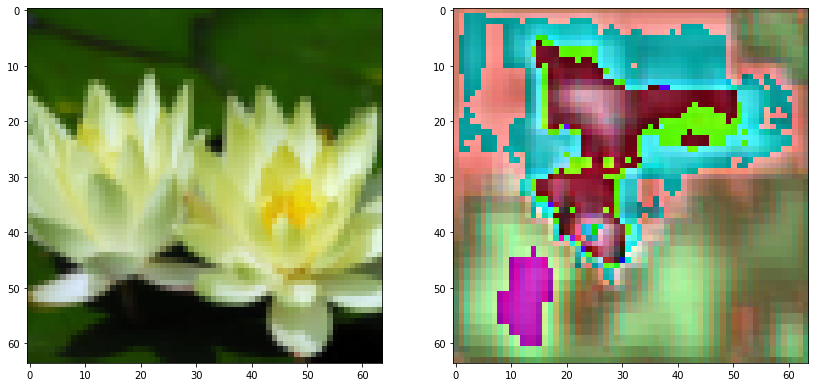

Base Caption: <start> this flower is yellow and white in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


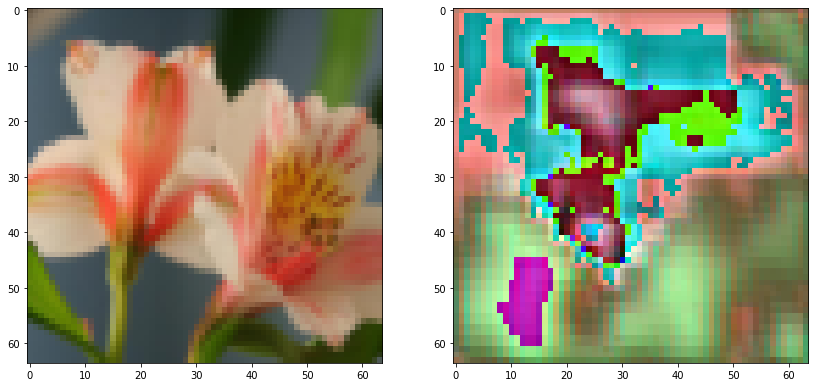

Base Caption: <start> this flower is white and pink in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


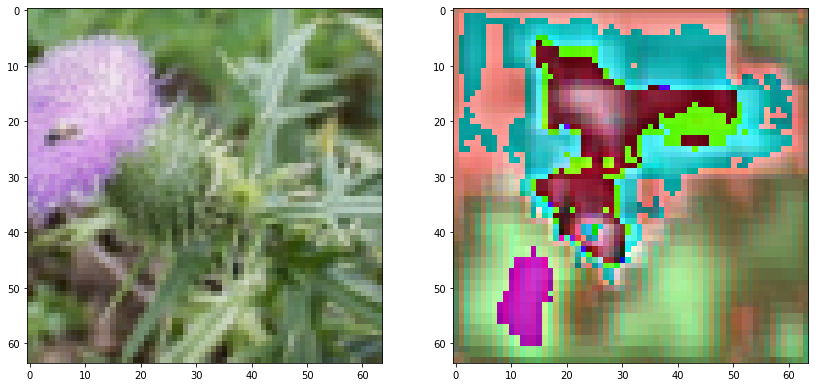

Base Caption: <start> this flower is green and purple in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


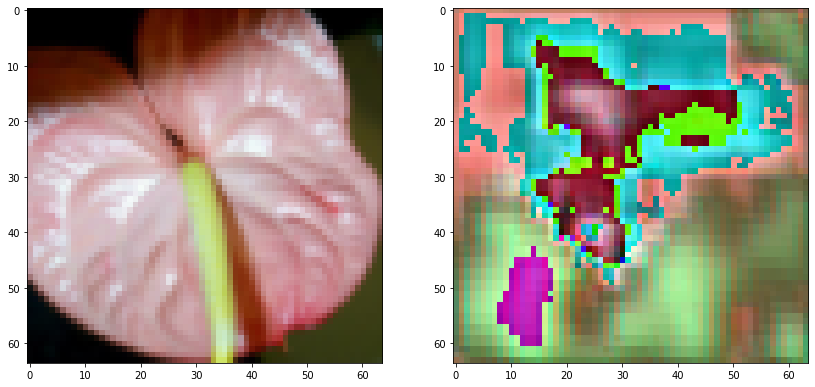

Base Caption: <start> this flower is yellow and pink in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


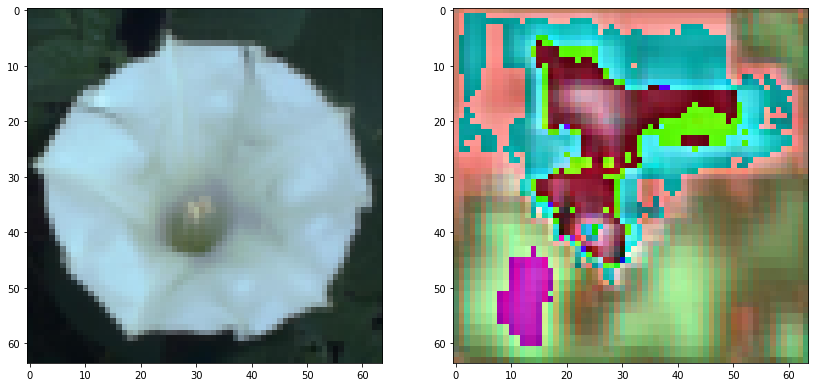

Base Caption: <start> this flower is white in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


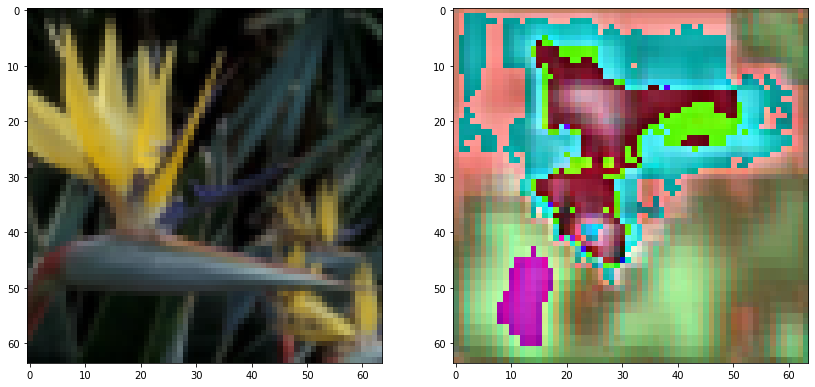

Base Caption: <start> this flower has sharp <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.6265244314579363
Discriminator Accuracy: 0.5

True Positive: 14640
False Positive (Deceived!): 14640.0
True Negative: 0
False Negative: 0.0
epoch6, iter2929, val loss: 9.579978200907265, epoch duration: 331.7262043952942


2it [00:00,  2.94it/s]

epoch7, iter0, loss: 6.1869809542258736e-06


202it [00:19, 10.45it/s]

epoch7, iter200, loss: 6.008166565152351e-06


403it [00:39, 10.33it/s]

epoch7, iter400, loss: 5.835312094859546e-06


603it [00:58, 10.56it/s]

epoch7, iter600, loss: 5.66245716981939e-06


802it [01:18, 10.33it/s]

epoch7, iter800, loss: 5.334629804565338e-06


1002it [01:37, 10.49it/s]

epoch7, iter1000, loss: 5.155814960744465e-06


1203it [01:57, 10.29it/s]

epoch7, iter1200, loss: 4.971039743395522e-06


1402it [02:16,  9.83it/s]

epoch7, iter1400, loss: 4.702817477664212e-06


1603it [02:36, 10.09it/s]

epoch7, iter1600, loss: 4.500160684983712e-06


1803it [02:56, 10.71it/s]

epoch7, iter1800, loss: 4.291543518775143e-06


2003it [03:15, 10.15it/s]

epoch7, iter2000, loss: 4.202136551612057e-06


2203it [03:35, 10.09it/s]

epoch7, iter2200, loss: 3.910071882273769e-06


2402it [03:55,  9.52it/s]

epoch7, iter2400, loss: 3.6656924748967867e-06


2603it [04:14, 10.30it/s]

epoch7, iter2600, loss: 3.4511147077864734e-06


2802it [04:33, 10.53it/s]

epoch7, iter2800, loss: 3.260379571656813e-06


2930it [04:46, 10.24it/s]


epoch7, iter2929, loss: 3.1828931241761893e-06, epoch duration: 286.8956735134125


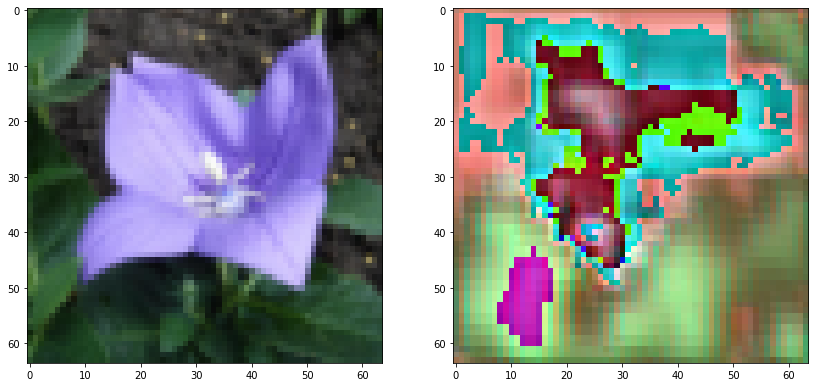

Base Caption: <start> this flower has wide bright blue petals with pointed tips and white stamen and a pistil at the center . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


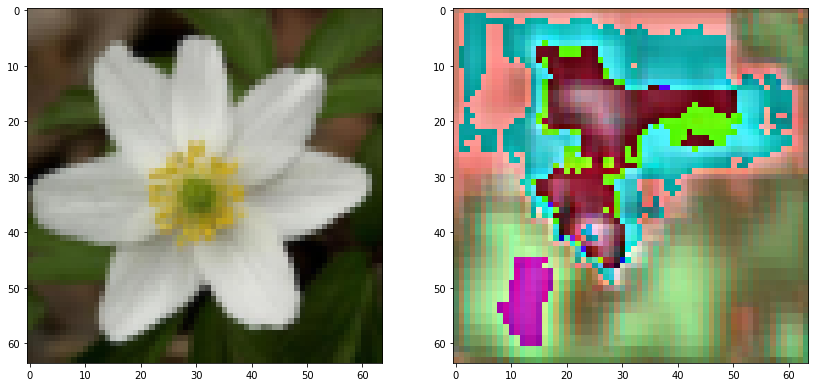

Base Caption: <start> this flower has seven leaf shaped white veined petals with fat yellow anther on short filaments . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


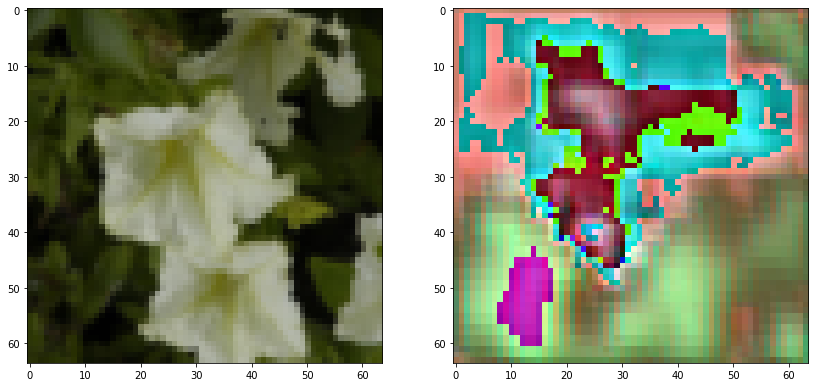

Base Caption: <start> this white and yellow flower has pointed petals and white stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


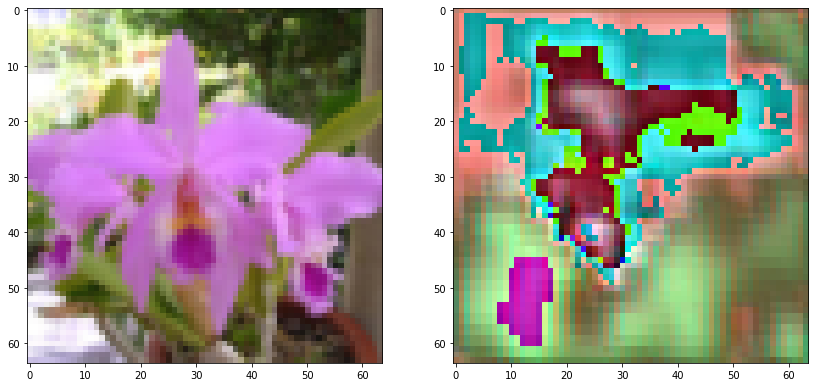

Base Caption: <start> this <unk> flower has ruffled purple feathers and smooth green leaves . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a purple center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


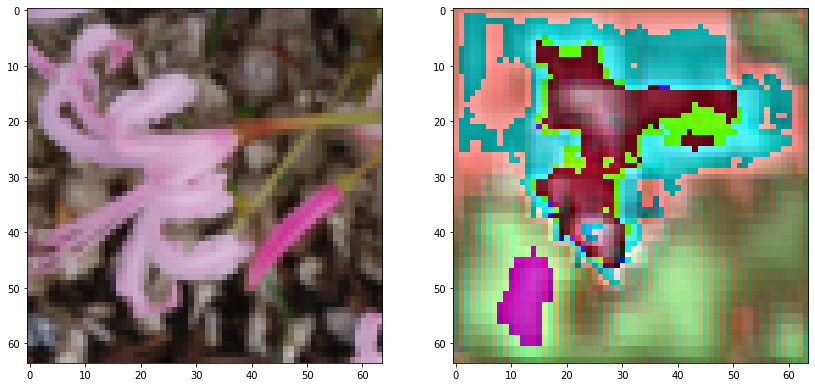

Base Caption: <start> this flower has tall pink stamen and long curled pink petals . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


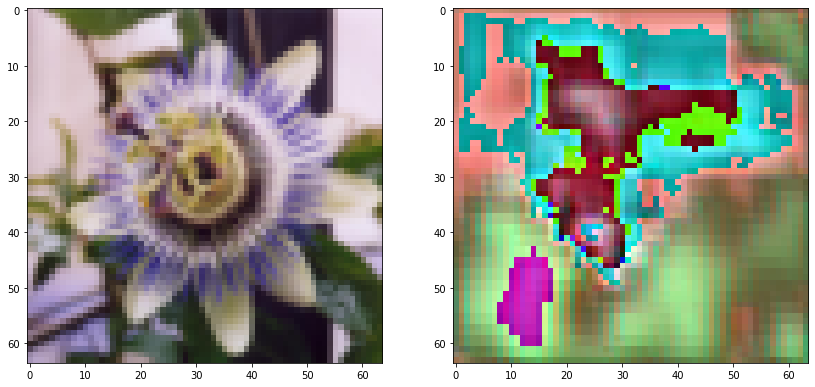

Base Caption: <start> this flower has petals that are white and has purple stringy stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


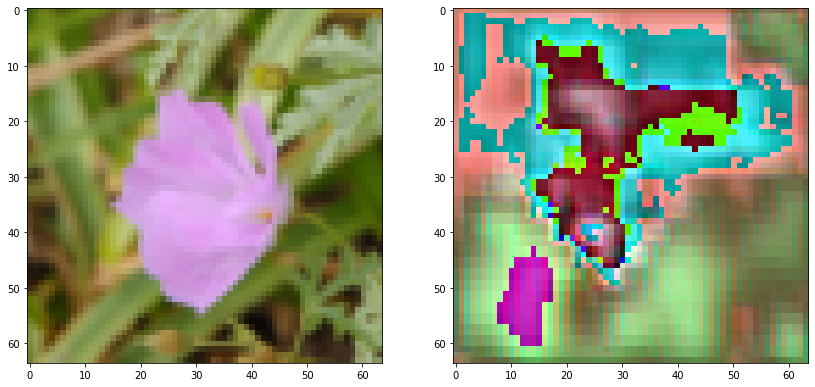

Base Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


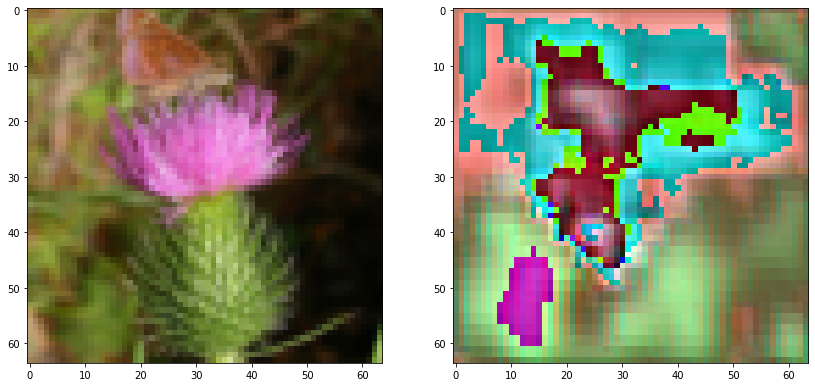

Base Caption: <start> this flower has petals that are green with pink stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


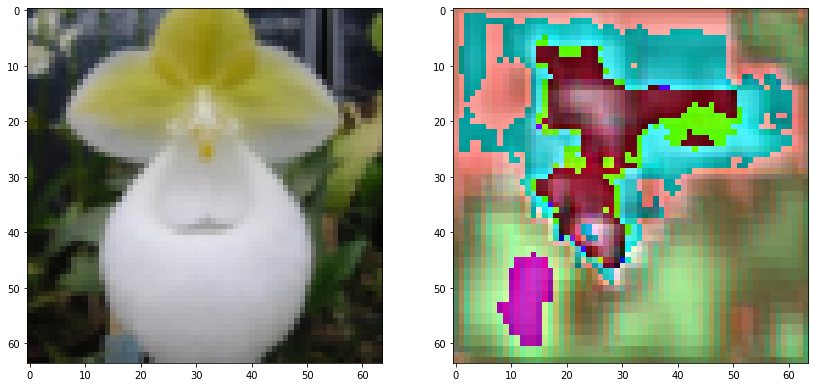

Base Caption: <start> this flower has large white petals <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


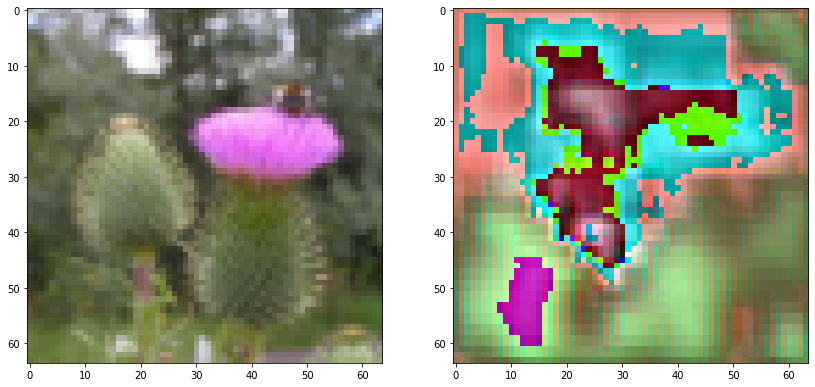

Base Caption: <start> sepals are green <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a flowery stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.6265251576249065
Discriminator Accuracy: 0.5

True Positive: 14640
False Positive (Deceived!): 14640.0
True Negative: 0
False Negative: 0.0
epoch7, iter2929, val loss: 9.633355231232981, epoch duration: 331.30312395095825


2it [00:00,  5.90it/s]

epoch8, iter0, loss: 12.664817810058594


202it [00:15, 12.69it/s]

epoch8, iter200, loss: 0.0001755629200488329


402it [00:31, 13.06it/s]

epoch8, iter400, loss: 0.00012292935571167618


602it [00:46, 12.89it/s]

epoch8, iter600, loss: 8.853375038597733e-05


802it [01:02, 13.12it/s]

epoch8, iter800, loss: 6.271799793466926e-05


1002it [01:17, 12.59it/s]

epoch8, iter1000, loss: 3.976357038482092e-05


1202it [01:33, 13.16it/s]

epoch8, iter1200, loss: 7.41017356631346e-05


1402it [01:48, 12.73it/s]

epoch8, iter1400, loss: 5.3000603656983e-05


1602it [02:04, 13.12it/s]

epoch8, iter1600, loss: 2.8196489438414574e-05


1802it [02:19, 12.87it/s]

epoch8, iter1800, loss: 3.306442886241712e-05


2002it [02:35, 12.43it/s]

epoch8, iter2000, loss: 2.5452358386246487e-05


2202it [02:50, 13.09it/s]

epoch8, iter2200, loss: 3.7728263123426586e-05


2402it [03:06, 13.64it/s]

epoch8, iter2400, loss: 2.2883083147462457e-05


2602it [03:22, 13.18it/s]

epoch8, iter2600, loss: 1.927136690937914e-05


2802it [03:37, 13.12it/s]

epoch8, iter2800, loss: 8.213542969315313e-06


2930it [03:47, 12.87it/s]


epoch8, iter2929, loss: 1.4668949006590992e-05, epoch duration: 228.44723105430603


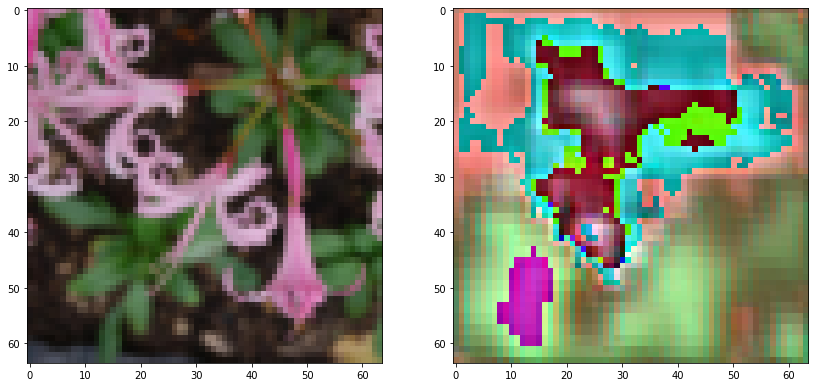

Base Caption: <start> this flower has petals that are pink and are very thin <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has red lines <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


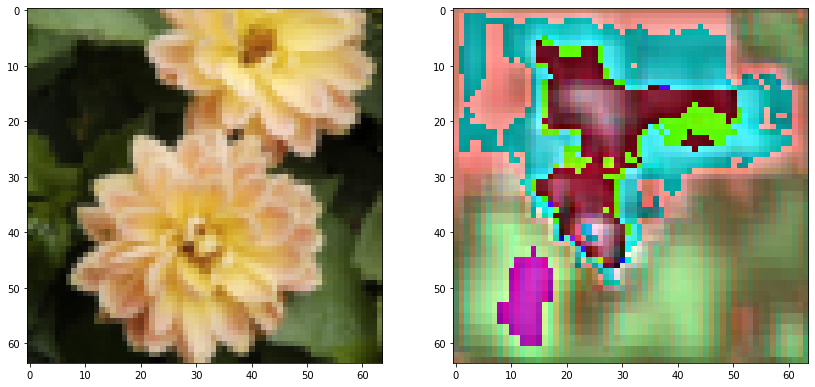

Base Caption: <start> this flower has petals that are orange with patches of yellow <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


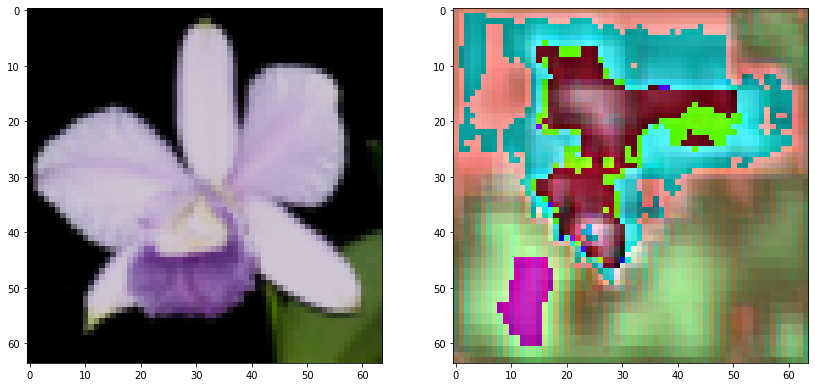

Base Caption: <start> a purple flower with ruffled petals and large green sepal . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


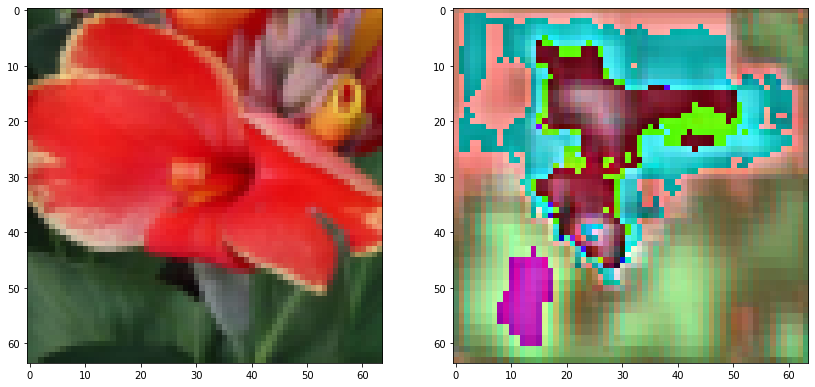

Base Caption: <start> this flower has petals that are red and has green edges <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


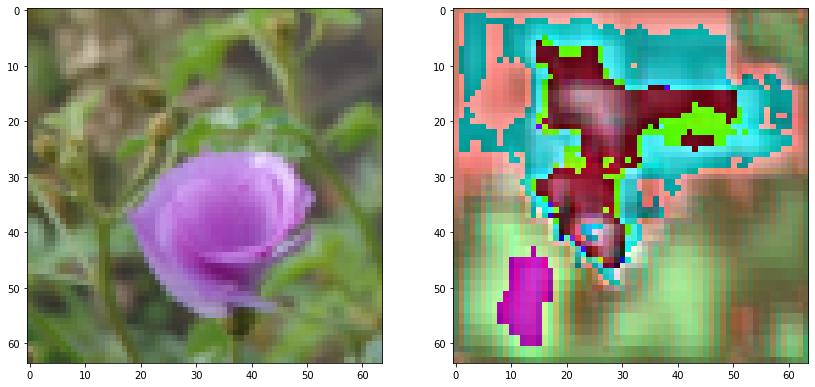

Base Caption: <start> a flower with long and wide petals that are purple . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


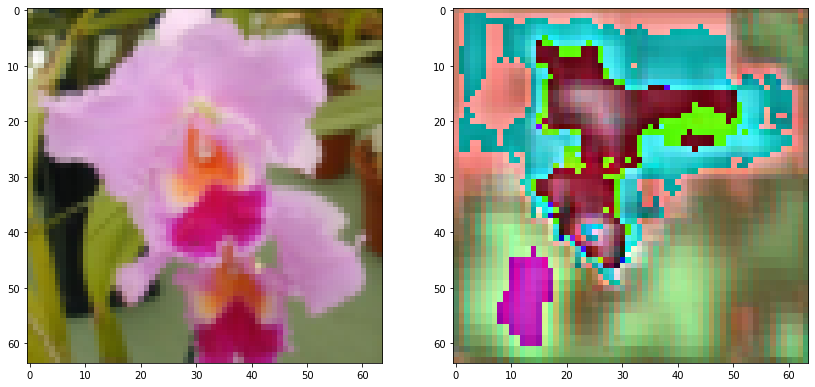

Base Caption: <start> this flower has petals that are pink with yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


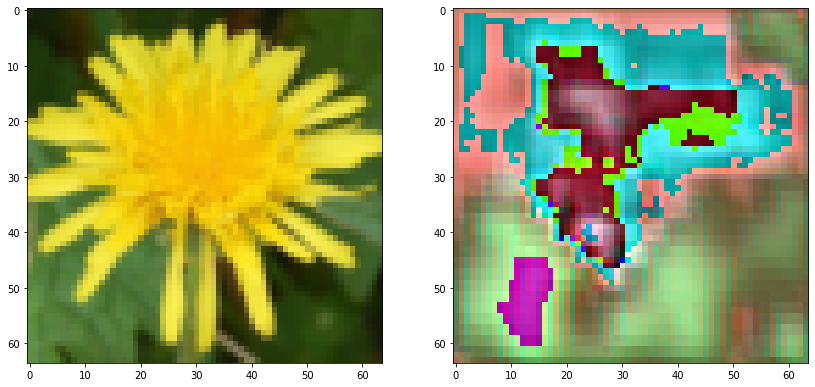

Base Caption: <start> yellow petaled flower with many petals with yellow stamens <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


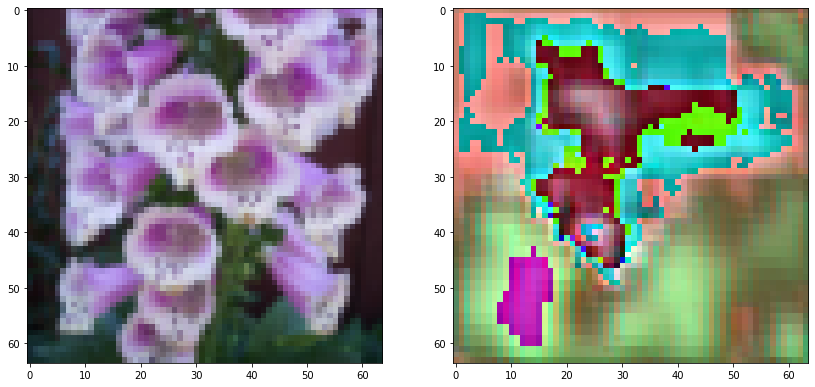

Base Caption: <start> this flower is pale purple with a white center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


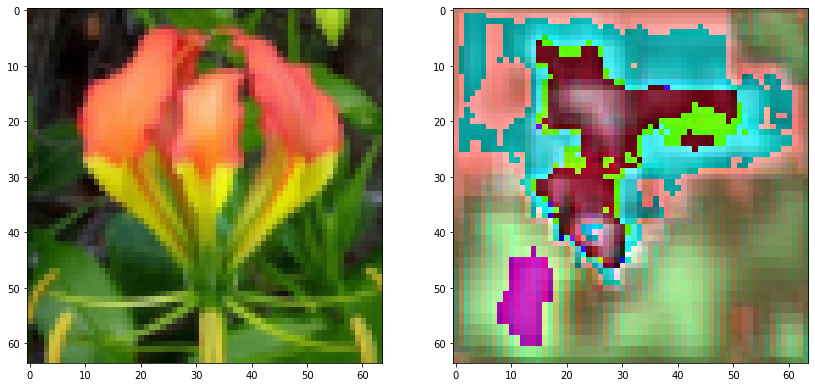

Base Caption: <start> this flower is yellow and red in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


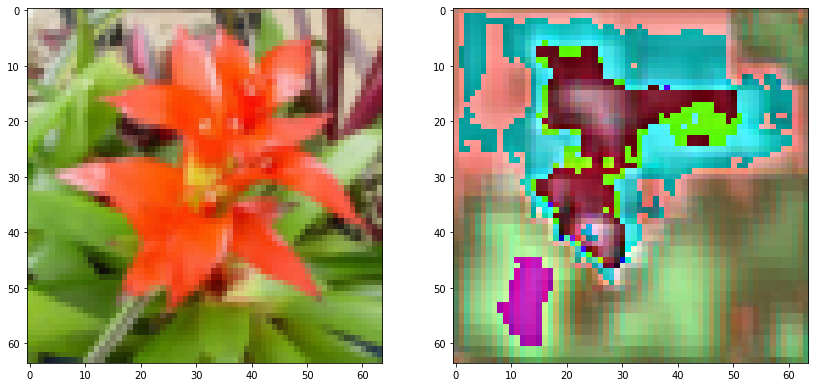

Base Caption: <start> a tall <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has a yellow style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.006542944517292
Discriminator Accuracy: 0.9999658469945355

True Positive: 14640
False Positive (Deceived!): 1.0
True Negative: 14639
False Negative: 0.0
epoch8, iter2929, val loss: 9.654458896709922, epoch duration: 273.3683099746704


2it [00:00,  2.61it/s]

epoch9, iter0, loss: 12.161319732666016


202it [00:19, 10.10it/s]

epoch9, iter200, loss: 2.159499672416132e-05


403it [00:39, 10.07it/s]

epoch9, iter400, loss: 2.1767855287180282e-05


601it [00:58, 10.19it/s]

epoch9, iter600, loss: 2.1428098989417776e-05


802it [01:18, 10.50it/s]

epoch9, iter800, loss: 2.152943125111051e-05


1003it [01:38, 10.14it/s]

epoch9, iter1000, loss: 2.082011997117661e-05


1201it [01:57, 10.54it/s]

epoch9, iter1200, loss: 2.0605537429219112e-05


1402it [02:17, 10.09it/s]

epoch9, iter1400, loss: 2.0432682504178956e-05


1601it [02:36, 10.23it/s]

epoch9, iter1600, loss: 2.0140614651609212e-05


1803it [02:56, 10.10it/s]

epoch9, iter1800, loss: 1.9961797079304233e-05


2002it [03:15, 10.73it/s]

epoch9, iter2000, loss: 1.9496870663715526e-05


2203it [03:35, 10.06it/s]

epoch9, iter2200, loss: 1.876371788966935e-05


2403it [03:54, 10.31it/s]

epoch9, iter2400, loss: 1.862066528701689e-05


2601it [04:14, 10.78it/s]

epoch9, iter2600, loss: 1.8268990970682353e-05


2802it [04:34, 10.42it/s]

epoch9, iter2800, loss: 1.7935199139174074e-05


2930it [04:46, 10.22it/s]


epoch9, iter2929, loss: 1.7571603166288696e-05, epoch duration: 287.42437648773193


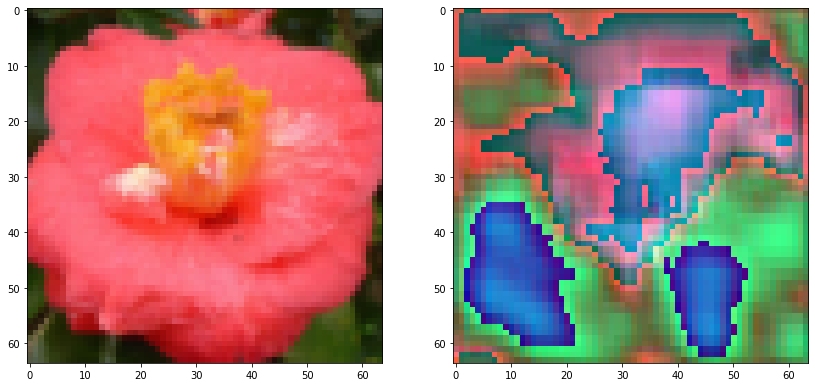

Base Caption: <start> this flower has bright pink petals with a round cluster of yellow stamen around a light brown stigma . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


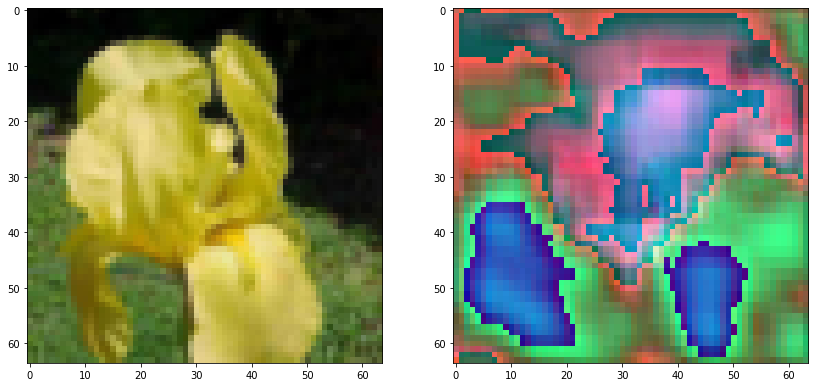

Base Caption: <start> this flower has several large yellow petals with rounded edges which are slightly ruffled and veined like leaves . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


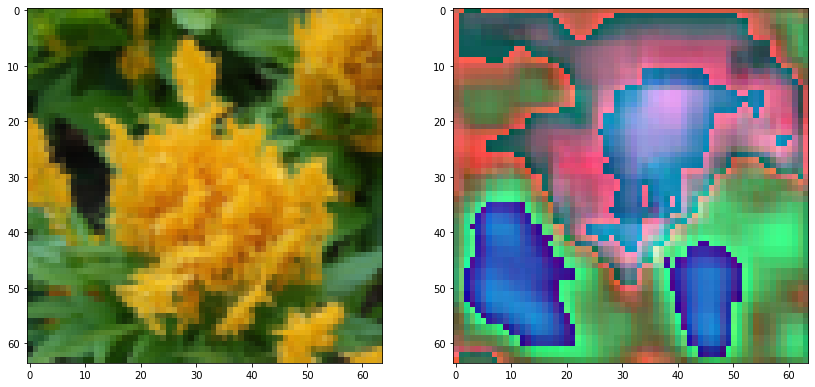

Base Caption: <start> this flower has bunched up petals curved into an upward position that are yellow-orange <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


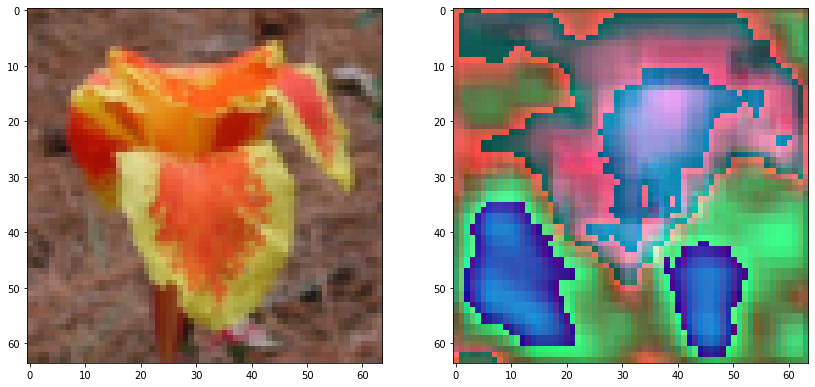

Base Caption: <start> this flower has very distinctive orange petals with an uneven yellow border . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


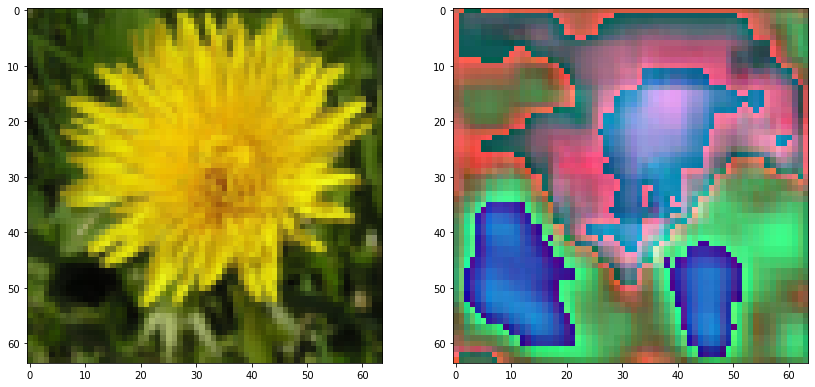

Base Caption: <start> this flower has a large number of very skinny bright petals . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


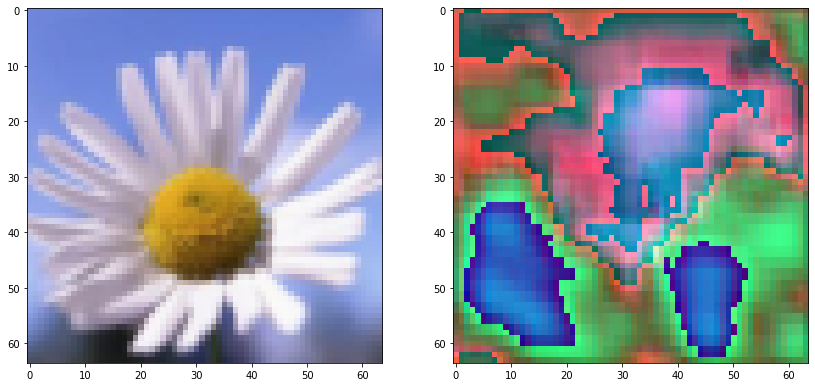

Base Caption: <start> this flower has thin white petals with a large yellow pistil . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


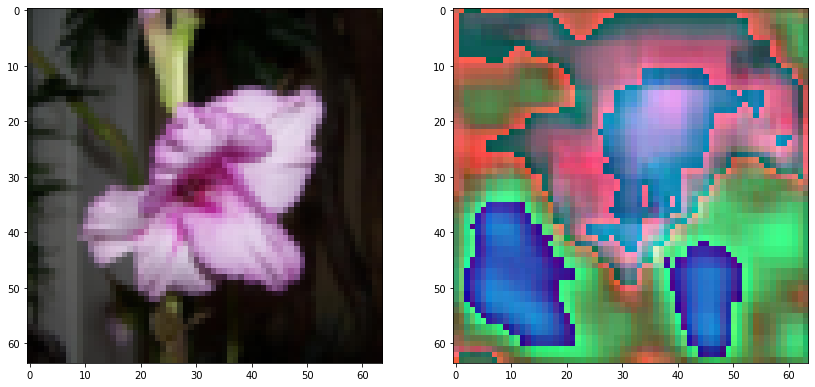

Base Caption: <start> this flower has petals that are pink and has purple shading <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


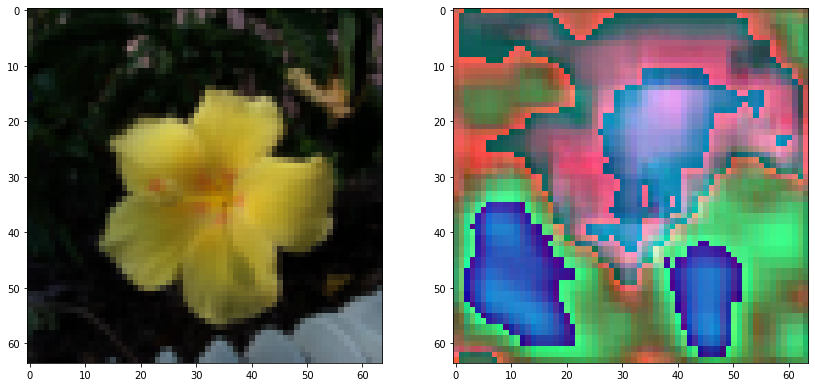

Base Caption: <start> this flower is yellow and pink in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


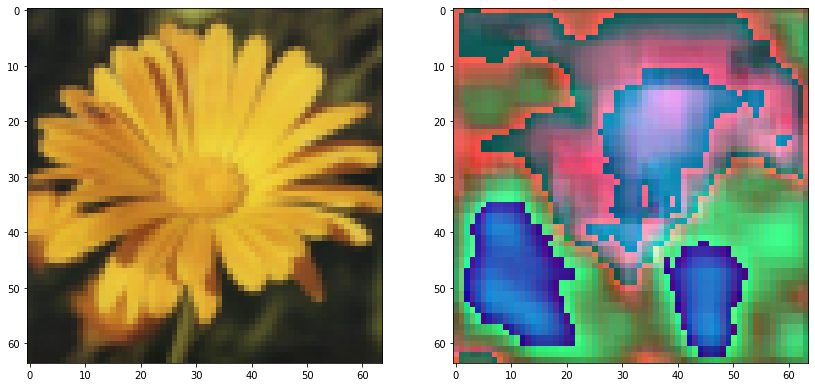

Base Caption: <start> this flower is yellow in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


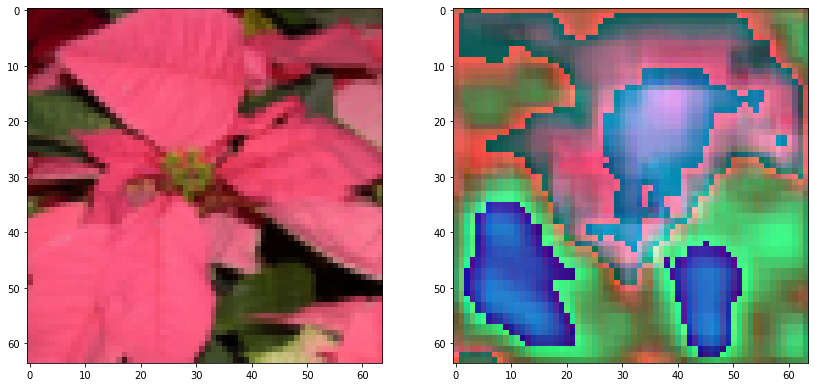

Base Caption: <start> large <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Discriminator loss: 1.6265140543869936
Discriminator Accuracy: 0.5

True Positive: 14640
False Positive (Deceived!): 14640.0
True Negative: 0
False Negative: 0.0
epoch9, iter2929, val loss: 9.461458350139889, epoch duration: 332.36023807525635


2it [00:00,  2.92it/s]

epoch10, iter0, loss: 1.7672933608992025e-05


203it [00:20, 10.40it/s]

epoch10, iter200, loss: 1.6945743482210673e-05


403it [00:39, 10.15it/s]

epoch10, iter400, loss: 1.6605990822426975e-05


538it [00:52, 10.41it/s]

In [ ]:
if __name__=='__main__':
    with open('trainvalIds.csv', 'r') as f:
        trainIds = []
        for line in f:
            if len(line) > 1:
                trainIds.append(line.strip("\n"))

        
    with open('testIds.csv', 'r') as f:
        testIds = []
        for line in f:
            if len(line) > 1:
                testIds.append(line.strip("\n"))
    
    print("found {} train ids".format(len(trainIds)))
    print("found {} test ids".format(len(testIds)))
    
    # Will shuffle the trainIds incase of ordering in csv
    random.shuffle(trainIds)
    splitIdx = int(len(trainIds)/5)
    
    # Selecting 1/5 of training set as validation
    valIds = trainIds[:splitIdx]
    trainIds = trainIds[splitIdx:]
    #print(trainIds)
    
    
    trainValRoot = "./data/realImages/"
    testRoot = "./data/realImages/"
    
    trainValCaps = "./data/captions/trainvalCaps.csv"
    testCaps = "./data/captions/testCaps.csv"
    
    
    with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
    
    img_side_length = 64
    transform = tf.Compose([
        tf.Resize(img_side_length),
        #tf.RandomCrop(img_side_length),
        tf.CenterCrop(img_side_length),
        tf.ToTensor(),
    ])
    batch_size = 20
    shuffle = True
    num_workers = 20
    
    
    trainDl = get_loader(trainValRoot, trainValCaps, trainIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    valDl = get_loader(trainValRoot, trainValCaps, valIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    testDl = get_loader(testRoot, testCaps, testIds, vocab, 
                        transform=transform, batch_size=batch_size, 
                        shuffle=shuffle, num_workers=num_workers)
    
    encoded_feature_dim = 800
    maxSeqLen = 49
    hidden_dim = 1500
    depth = 1
    
    embed = torch.load('./weights/bs{}_embed_best'.format(batch_size))
    
    encoder = torch.load('./weights/lstm{}encoder_best'.format(img_side_length))
    decoder = torch.load('./weights/lstm{}decoder_best'.format(img_side_length))
    # Turn off all gradients in encoder
    for param in embed.parameters():
        param.requires_grad = False
        
    for param in encoder.parameters():
        param.requires_grad = False

    for param in decoder.parameters():
        param.requires_grad = False

    
#     criterion = nn.NLLLoss()
    stackZero = BaseGenerator(batch_size, embed.hidden_dim)
    #stackZero = torch.load('./weights/stack0_genOnly_epoch63')
    epochs = 100
    disc_gen_split = 4
    lam = 0
    trainStack(encoder, decoder, embed, stackZero, epochs, trainDl, valDl, testDl, "genOnly",
                batch_size, maxSeqLen, vocab, lam, disc_gen_split,save_generated_imgs = False)

In [ ]:
%debug

In [ ]:
with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
vocab.idx

In [ ]:
import torch
import torch.optim as optim
import os
#print(os.getcwd())
embed = torch.load('./weights/base_embed_best')
embed.batch_size
optimizer = optim.Adam(list(embed.parameters()), lr=5e-5)

help(optimizer.step)
